<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="50%" height="50%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales II-2018 </h1>

<H3 align='center'> Tarea 2 - Redes Convolucionales y sus aplicaciones </H3>
<hr style="height:2px;border:none"/>

**Integrantes**  
* Jorge Núñez C. 201211508-6
* Tomás Ochoa A. 201423007-9


# 1. Convolutional Neural Networks (CNN) en CIFAR

En esta sección se trabajará con un dataset consistente en un conjunto de 60.000 imágenes RGB de 32x32 pixeles que contiene 10 clases de objetos y 6.000 ejemplos por clase. La versión utilizada viene separada en 50.000 ejemplos de entrenamiento y 10.000 casos de prueba que fueron obtenidos seleccionando 1.000 imágenes aleatorias de cada clase.

> Los datos restantes han sido ordenados aleatoriamente y están organizados en 5 bloques de entrenamiento o batches. Cabe destacar que las clases son mutuamente excluyentes y corresponden a las siguientes categorías.

* Gato
* Perro
* Rana
* Caballo
* Pájaro
* Ciervo
* Avión
* Automóvil
* Camión 
* Barco

Se procede a experimentar con redes convolucionales, conocidas como CNNs o ConvNets


> **a)** Inicialmente se construye una función que cargue todos los bloques de entrenamiento y pruebas del problema CIFAR generando como salida:
(i) dos matrices Xtr, Ytr; correspondientes a las imágenes y etiquetas de entrenamiento
(ii) dos matrices Xt, Yt; correspondientes a las imágenes y etiquetas de pruebas
(iii) dos matrices Xv, Yv; correspondientes a las imágenes y etiquetas que se usarán como conjunto de validación (para tomar decisiones de diseño acerca del modelo)
Este último conjunto es extraído del conjunto de entrenamiento original y no debe superar las 5.000 imágenes



In [0]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']  
import numpy as np   
import os   
from keras import metrics
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Se procede a separar el conjunto de entrenamiento en dos, utilizando 2.500 imágenes de este para crear el conjunto de validación

In [0]:
from sklearn.cross_validation import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05)

> **b)** Preparación de subconjuntos de entrenamiento, validación y pruebas normalizando las imágenes de entrenamiento, validación y pruebas, dividiendo las intensidades originales de pixel en cada canal por 255.

In [0]:
x_train=x_train/255
x_val=x_val/255
x_test=x_test/255

Se procede a generar una representación binaria para los vectores de salida creando para cada dato de salida un vector de tamaño 10 donde tan solo una dimensión de este es de valor unitario y el resto de valor cero, la dimensión en que se ubica el valor unitario es atrubuida a la clase que pertenece esta salida.

In [0]:
import keras
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_val = keras.utils.to_categorical(y_val, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [6]:
x_train.shape

(47500, 32, 32, 3)

> **c)** Se define una CNN con arquitectura $C \times P \times C \times P \times F \times F$. Para ambas capas convolucionales se utilizan 64 filtros de $3 \times 3$ y funciones de activación ReLU. Para las capas de pooling se usan filtros de $2 \times 2$ con stride 2. Para la capa MLP escondida se usan 512 neuronas.

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

*Observación: Al añadir al modelo una capa Conv2D esta por defecto incluye un bias el cual tiene asociado un peso para cada filtro afectando el número de parámetros entrenables por lo que el número de parámetros asociados a esta capa viene dado por:* 
 $ancho\ filto * altura\ filtro * n°\ canales\ de\ entrada* n° filtros+n° pesos\ biases=3*3*3*64+64=1.792$. <br> 

 *Luego la capa de activación y  max_pooling no brindan nuevos parámetros a la red, esta última disminuye las dimensiones asociadas al número de pixeles de la imágen a la mitad seleccionando. El número de canales de entrada de la siguiente capa Conv2D pasa a ser el número de filtros de la capa anterior resultando:* <br>
 $ancho\ filto * altura\ filtro * n°\ canales\ de\ entrada* n° filtros+n° pesos\ biases=3*3*64*64+64=36.928$. <br> 


 *Al aplicar nuevamente una capa de activación y max_pooling luego se utiliza la capa flatten para desplegar la imágen de 8x8x64 en 4096 datos en una única columna para ser utilizados de input para una capa oculta tradicional de densidad 512 donde el número de parámetros viene dado por:*
 $dimensión\ input*n°\ de\ neuronas+n° pesos\ asociados\ a\ biases = 512*4096+512=2.097.664$

 *Finalmente la capa softmax recibe la salida de cada neurona de la capa oculta más un bias resultando:*
  $dimensión\ input *n°\ de\ neuronas+n° pesos\ asociados\ a\ biases= 512*10+10=5.130$




> **d)**  Se procede a entrenar la red neuronal creada en **c)** utilizando SGD. Se controla la tasa de aprendizaje utilizada en el entrenamiento implementando la siguiente idea: partir con una tasa de aprendizaje $\eta = 10^{-3}$ y dividir por 2 ese valor cada 10 epochs, esto con la restricción de no usar una tasa de aprendizaje menor a $\eta = 10^{-5}$ lo cual no será problema dado que se entrena utilizando 25 epochs.

In [0]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler, History
import math

def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/10))
    lrate = max(lrate,0.00001)
    return lrate

hist = History()
opt = SGD(lr=0, momentum=0.9)
lrate = LearningRateScheduler(step_decay,verbose=1)
model.compile(opt,loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
history = model.fit(x_train, y_train,epochs=25, validation_data=(x_val,y_val), shuffle=True, callbacks=[hist,lrate])
score, acc= model.evaluate(x_test, y_test)

*Se procede a graficar los errores de entrenamiento y validación obtenidos*

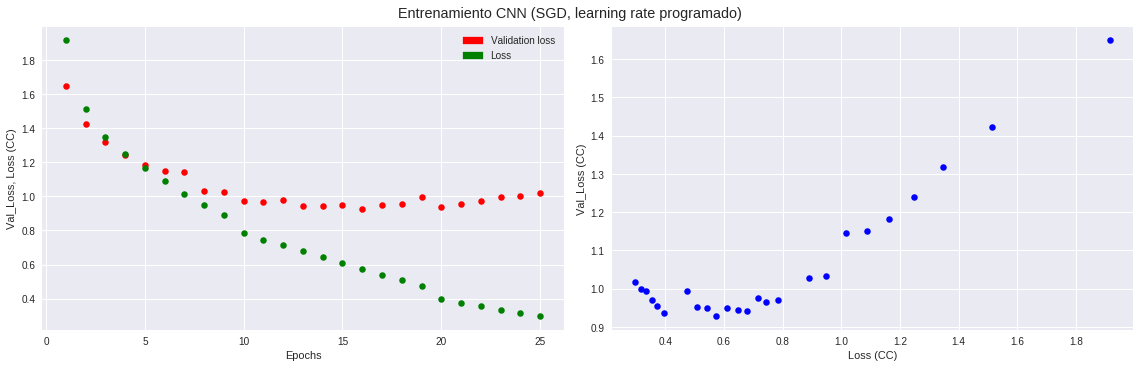

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
a=np.linspace(1,25,25)
plt.rcParams["figure.figsize"] = [16,5]
plt.suptitle('Entrenamiento CNN (SGD, learning rate programado)',y=1.02)
plt.subplot(1,2,1)
plt.plot(a,hist.history['val_loss'],'r.',markersize=13)
red=mpatches.Patch(color='red', label='Validation loss')
plt.plot(a,hist.history['loss'],'g.', markersize=13)
green=mpatches.Patch(color='green', label='Loss')
plt.legend(handles=[red,green])
plt.xlabel('Epochs')
plt.ylabel('Val_Loss, Loss (CC)')
plt.subplot(1,2,2)
plt.plot(hist.history['loss'],hist.history['val_loss'],'b.',markersize=13)
plt.xlabel('Loss (CC)')
plt.ylabel('Val_Loss (CC)')
plt.tight_layout()
plt.show()

*Comentario: Pese a la disminución de learning rate programada se visualiza fácilmente un sobreajuste a lo largo del proceso de entrenamiento, es más se ve que precisamente en el epoch 10 donde se disminuyó el learning rate se estanca el avance del error de validación, por lo cual en los siguientes items en que se ocupe SGD se buscará modificar el learning rate programado a la vez de buscar técnicas para enfrentar el sobre ajuste.*

El error y accuracy de test mientras tanto resulta en:

In [0]:
score,acc

(1.021715051841736, 0.6892)

> **e)** Se procede a entrenar la CNN definida en c) utilizando **RMSProp** durante 25 *epochs* con un decay de 1e-06. Se utiliza la función de pérdida categorical crossentropy .

In [0]:
#...
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
#...
from keras.optimizers import SGD, rmsprop
hist1= History()
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(opt,loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
history = model.fit(x_train, y_train,epochs=25, validation_data=(x_val,y_val), shuffle=True, callbacks=[hist1])
score1, acc1 = model.evaluate(x_test, y_test)


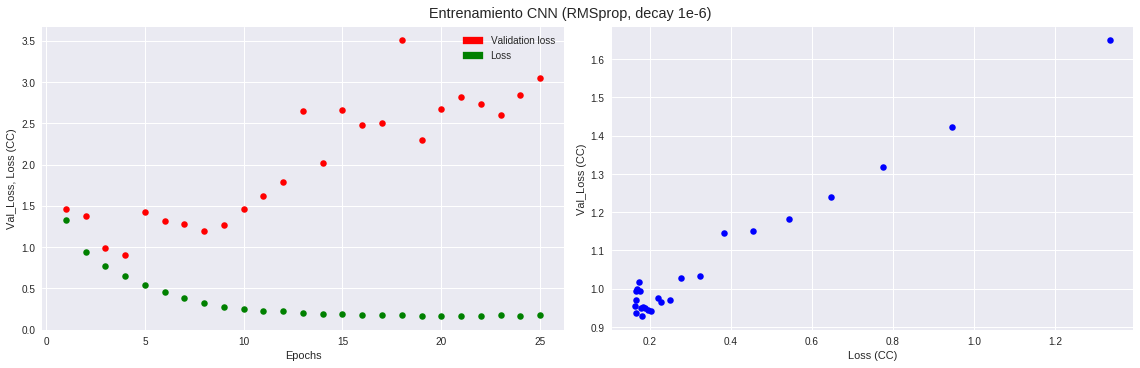

In [0]:
a=np.linspace(1,25,25)
plt.rcParams["figure.figsize"] = [16,5]
plt.suptitle('Entrenamiento CNN (RMSprop, decay 1e-6)',y=1.02)
plt.subplot(1,2,1)
plt.plot(a,hist1.history['val_loss'],'r.',markersize=13)
red=mpatches.Patch(color='red', label='Validation loss')
plt.plot(a,hist1.history['loss'],'g.',markersize=13)
green=mpatches.Patch(color='green', label='Loss')
plt.legend(handles=[red,green])
plt.xlabel('Epochs')
plt.ylabel('Val_Loss, Loss (CC)')
plt.subplot(1,2,2)
plt.plot(hist1.history['loss'],hist.history['val_loss'],'b.',markersize=13)
plt.xlabel('Loss (CC)')
plt.ylabel('Val_Loss (CC)')
plt.tight_layout()
plt.show()

*Comentario: Resulta claro el overfitting presente luego del epoch 4.*

El error y accuracy de test mientras tanto resulta en:

In [0]:
score1,acc1

(2.9972432446479798, 0.6945)

*Comentario: Resultado que es mejor que el caso previo pese al sobre ajuste que continúa a partir del epoch 5, esto dado que keras guarda el mejor desempeño en validación como modelo, luego se aplica la predicción del conjunto de test con este modelo.*

> **f)** A continuación se procede a experimentar el efecto de modificar el tamaño de los filtros (de convolución) reportando la sensibilidad del error de pruebas a estos cambios en dos tipos de arquitecturas, una profunda y otra no. Presente un gráfico o tabla resumen. Se realizan 25 epochs para cada red para lograr visualizar de mejor manera su comportamiento.

Para realizar el entrenamiento se plantean las dos arquitecturas (profunda y no profunda) y se crea una matriz que contenga la variación del tamaño de filtros deseados para ambas redes, luego se procede a entrenar ambas redes por medio de una iteración sobre esta matriz, adicionalmente se modifica el learning rate programado para que en un inicio tenga un valor elevado y reduzca cada 4 epochs a la mitad con un valor mínimo de 0.00001.

Para enfrentar el overfitting se procede a añadir regularizadores de pesos y añadir dropout.

In [0]:
from keras.callbacks import LearningRateScheduler, History
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
from keras.optimizers import SGD, rmsprop
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from keras.regularizers import l2

def step_decay(epoch):
    initial_lrate = 0.005
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/3))
    lrate = max(lrate,0.00001)
    return lrate

knp=list()
kp=list()
paramgrid=np.array([2,3,4,5])
sc2=list()
ac2=list()
sc3=list()
ac3=list()
for i in range(4):
  model = Sequential()
  model.add(Conv2D(64, (paramgrid[i], paramgrid[i]), padding='same', input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Dropout(0.25))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  hist3 = History()
  opt = SGD(lr=0,momentum=0.9)
  lrate = LearningRateScheduler(step_decay,verbose=1)
  model.compile(opt,loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
  history = model.fit(x_train, y_train,epochs=20, validation_data=(x_val,y_val), shuffle=True, callbacks=[hist3,lrate])
  score2, acc2 = model.evaluate(x_test, y_test)
  sc2.append(score2)
  ac2.append(acc2)
  knp.append(hist3.history)
  model = Sequential()
  model.add(Conv2D(64, (paramgrid[i], paramgrid[i]), padding='same', input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
  model.add(Conv2D(64, (paramgrid[i], paramgrid[i]), padding='same', W_regularizer=l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  hist3=History()
  opt = SGD(lr=0,momentum=0.9)
  lrate = LearningRateScheduler(step_decay,verbose=1)
  model.compile(opt,loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
  history = model.fit(x_train, y_train,epochs=20, validation_data=(x_val,y_val), shuffle=True, callbacks=[hist3,lrate])
  score3, acc3 = model.evaluate(x_test, y_test)
  sc3.append(score3)
  ac3.append(acc3)
  kp.append(hist3.history)
  

Se procede a graficar los errores obtenidos en el conjunto de entrenamiento y validación.

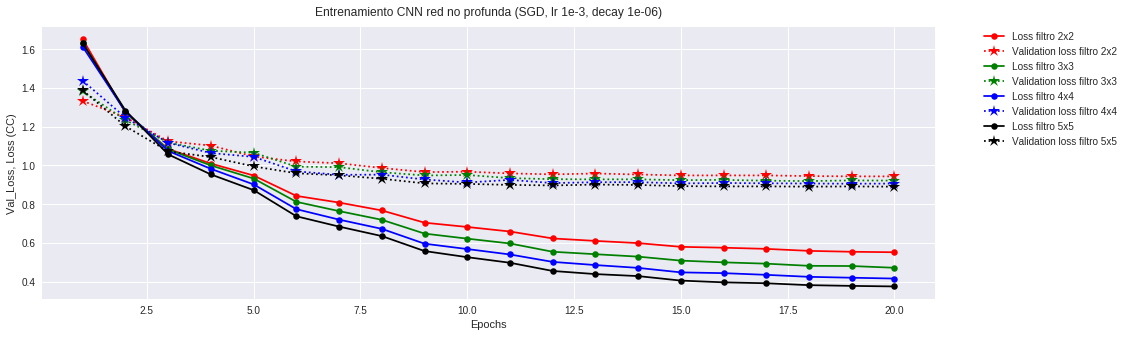

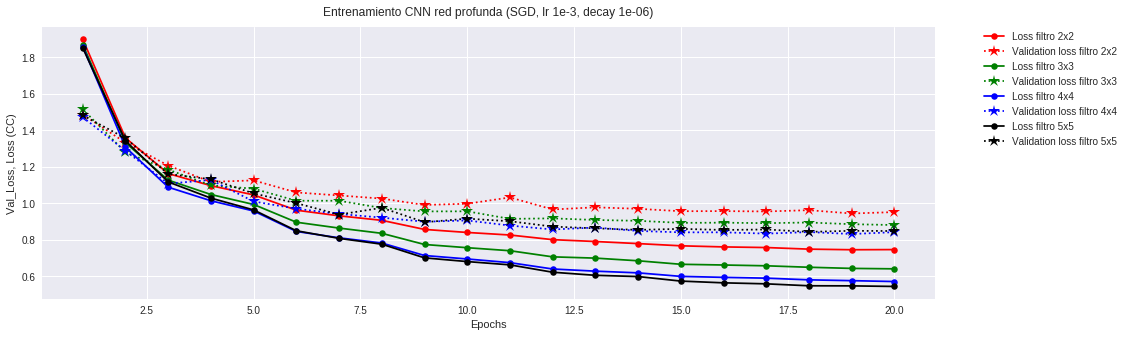

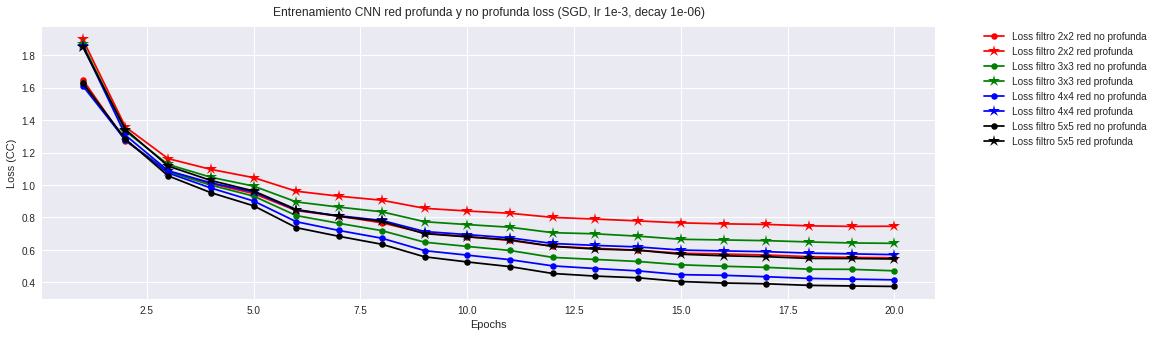

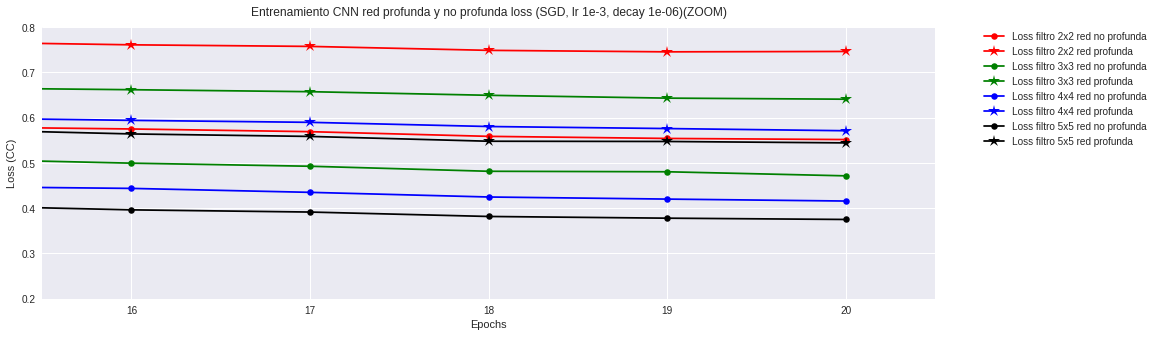

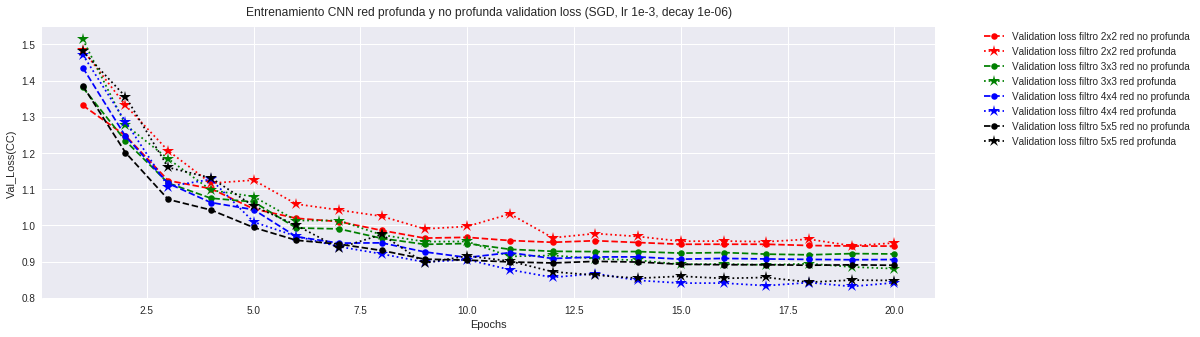

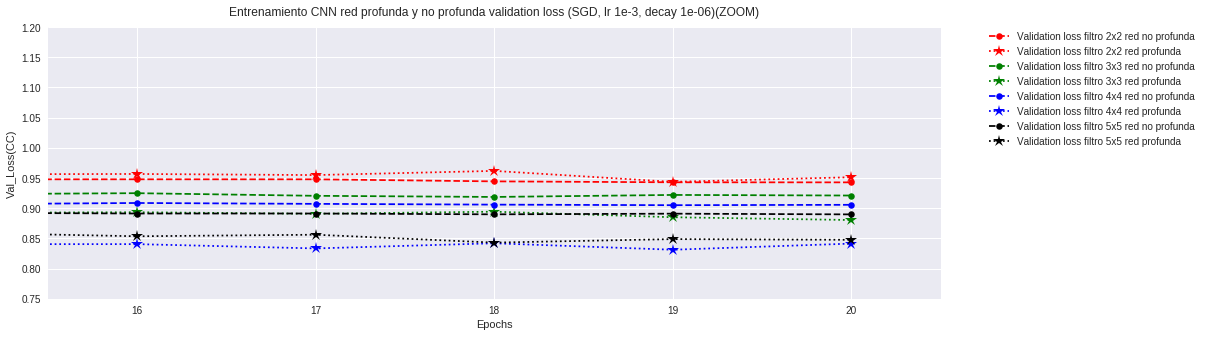

In [9]:
a=np.linspace(1,20,20)
plt.rcParams["figure.figsize"] = [16,5]
plt.title('Entrenamiento CNN red no profunda (SGD, lr 1e-3, decay 1e-06)',y=1.02)
nloss=['Loss filtro 2x2','Loss filtro 3x3','Loss filtro 4x4','Loss filtro 5x5',]
nvalloss=['Validation loss filtro 2x2','Validation loss filtro 3x3','Validation loss filtro 4x4','Validation loss filtro 5x5',]
colp=['r*:','g*:','b*:','k*:']
cols=['r.-','g.-','b.-','k.-']
for i in range(4):
  plt.plot(a,knp[i]['loss'],cols[i],label=nloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.plot(a,knp[i]['val_loss'],colp[i],label=nvalloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Val_Loss, Loss (CC)')
plt.show()

plt.title('Entrenamiento CNN red profunda (SGD, lr 1e-3, decay 1e-06)',y=1.02)
for i in range(4):
  plt.plot(a,kp[i]['loss'],cols[i],label=nloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.plot(a,kp[i]['val_loss'],colp[i],label=nvalloss[i],markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Val_Loss, Loss (CC)')
plt.show()

colp=['r*-','g*-','b*-','k*-']
cols=['r.-','g.-','b.-','k.-']

plt.title('Entrenamiento CNN red profunda y no profunda loss (SGD, lr 1e-3, decay 1e-06)',y=1.02)
for i in range(4):
  plt.plot(a,knp[i]['loss'],cols[i],label=nloss[i]+str(' red no profunda'),markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.plot(a,kp[i]['loss'],colp[i],label=nloss[i]+str(' red profunda'),markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Loss (CC)')
plt.show()

plt.title('Entrenamiento CNN red profunda y no profunda loss (SGD, lr 1e-3, decay 1e-06)(ZOOM)',y=1.02)
for i in range(4):
  plt.plot(a,knp[i]['loss'],cols[i],label=nloss[i]+str(' red no profunda'),markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.plot(a,kp[i]['loss'],colp[i],label=nloss[i]+str(' red profunda'),markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Loss (CC)')
plt.ylim([0.2,0.8])
plt.xlim([15.5,20.5])
plt.show()

colp=['r*:','g*:','b*:','k*:']
cols=['r.--','g.--','b.--','k.--']

plt.title('Entrenamiento CNN red profunda y no profunda validation loss (SGD, lr 1e-3, decay 1e-06)',y=1.02)
for i in range(4):
  plt.plot(a,knp[i]['val_loss'],cols[i],label=nvalloss[i]+str(' red no profunda'),markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.plot(a,kp[i]['val_loss'],colp[i],label=nvalloss[i]+str(' red profunda'),markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Val_Loss(CC)')
plt.show()

plt.title('Entrenamiento CNN red profunda y no profunda validation loss (SGD, lr 1e-3, decay 1e-06)(ZOOM)',y=1.02)
for i in range(4):
  plt.plot(a,knp[i]['val_loss'],cols[i],label=nvalloss[i]+str(' red no profunda'),markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.plot(a,kp[i]['val_loss'],colp[i],label=nvalloss[i]+str(' red profunda'),markersize=13)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Val_Loss(CC)')
plt.ylim([0.75,1.2])
plt.xlim([15.5,20.5])
plt.show()


*Comentario: Respecto al conjunto de entrenamiento es claro que su pérdida se comporta de mejor manera a medida que se aumenta el tamaño del filtro en la red tanto en la red profunda como no profunda, desempeñándose de mucha mejor forma la red profunda al hacer la comparación entre ambas. En cuanto al error de validación, se ve que la red profunda presenta mejor desempeño que la red no profunda, con excepción del caso que cuenta con filtros de tamaño 2x2, a la vez se ve que el mejor rendimiento para la red no profunda se produce para un filtro de tamaño 4x4 mientras que para la red profunda se produce para el filtro 5x5 no siendo coherentes estos resultados respecto al error del conjunto de entrenamiento.*

*Por último destacar que el mejor comportamiento de la red profunda se puede deber a que esta cuenta con mayor cantidad de caractarísticas sustraídas de las imágenes de entrada, la capa inicial de convolución sirve por lo general para reconocer bordes, por lo que contar solo con esta información es insuficiente, luego contar con una capa convolucional extra permite obtener conceptos de mayor nivel, por ejemplo reconocimiento de objetos o rostros, a medida que se van añadiendo capas convolucionales la abstracción de conceptos se vuelve cada vez más específica.*

In [10]:
for i in range(4):
  print('red no profunda ',str(paramgrid[i]),'x',str(paramgrid[i])+ ' error y accuracy: '+str(sc2[i])+', '+str(ac2[i])+'\n')
for i in range(4):
  print('red profunda ',str(paramgrid[i]),'x',str(paramgrid[i])+ ' error y accuracy: '+str(sc3[i])+', '+str(ac3[i])+'\n')

red no profunda  2 x 2 error y accuracy: 0.9267842503547669, 0.6771

red no profunda  3 x 3 error y accuracy: 0.9008686392784119, 0.6853

red no profunda  4 x 4 error y accuracy: 0.8933741499900818, 0.6903

red no profunda  5 x 5 error y accuracy: 0.8826669086456299, 0.6967

red profunda  2 x 2 error y accuracy: 0.9397433102607727, 0.6992

red profunda  3 x 3 error y accuracy: 0.8723432470321655, 0.7188

red profunda  4 x 4 error y accuracy: 0.8306662976264954, 0.7398

red profunda  5 x 5 error y accuracy: 0.8299224632263184, 0.7391



*Comentario: Se logran predicciones de alta efectividad, del modo que son desplegados los accuracy de cada red se ve una mejora continua con excepción del último caso. Esto ayuda a reforzar el hecho de que se logra un mejor desempeño utilizando una red profunda, a la vez que ocupar filtros de tamaños 4x4 o bien 5x5 resulta en una red de mejor calidad (La diferencia de calidad de predicción entre las dos de mayor tamaño no es amplia).*

> **g)** Una práctica habitual es continuar una capa convolucional con una capa de *pooling* , lo cual puede generar una reducción prematura de las dimensiones del patrón de entrada. Se procede a experimentar con una arquitectura del tipo $C \times P \times C \times P \times F \times F$ versus  $C \times C \times P \times C \times C \times P \times F \times F$.


In [0]:

from keras.callbacks import LearningRateScheduler, History
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
from keras.optimizers import SGD, rmsprop
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from keras.regularizers import l2

def step_decay(epoch):
    initial_lrate = 0.005
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/3))
    lrate = max(lrate,0.00001)
    return lrate

hist4 = History()
model = Sequential()
model.add(Conv2D(64, (5, 5), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), padding='same', W_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
opt = SGD(lr=0,momentum=0.9)
lrate = LearningRateScheduler(step_decay,verbose=1)
model.compile(opt,loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
history = model.fit(x_train, y_train,epochs=20, validation_data=(x_val,y_val), shuffle=True, callbacks=[hist4,lrate])
score4, acc4 = model.evaluate(x_test, y_test)

filt1=[5,3]
filt2=[3,5]
sc5=list()
ac5=list()
kg=list()

for i in range(2):
  hist5 = History()
  model = Sequential()
  model.add(Conv2D(64, (filt1[i], filt1[i]), padding='same', input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (filt1[i], filt1[i]), padding='same', W_regularizer=l2(0.015)))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(128, (filt2[i], filt2[i]), padding='same', W_regularizer=l2(0.015)))
  model.add(Activation('relu'))
  model.add(Conv2D(128, (filt2[i], filt2[i]), padding='same'))
  model.add(Dropout(0.5))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  opt = SGD(lr=0,momentum=0.9)
  lrate = LearningRateScheduler(step_decay,verbose=1)
  model.compile(opt,loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
  history = model.fit(x_train, y_train,epochs=20, validation_data=(x_val,y_val), shuffle=True, callbacks=[hist5,lrate])
  score5, acc5 = model.evaluate(x_test, y_test)
  kg.append(hist5.history)
  sc5.append(score5)
  ac5.append(acc5)

Se proceden a graficar los resultados obtenidos

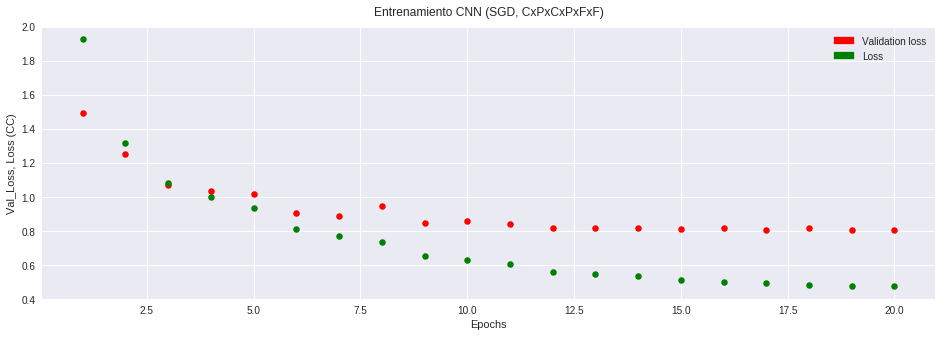

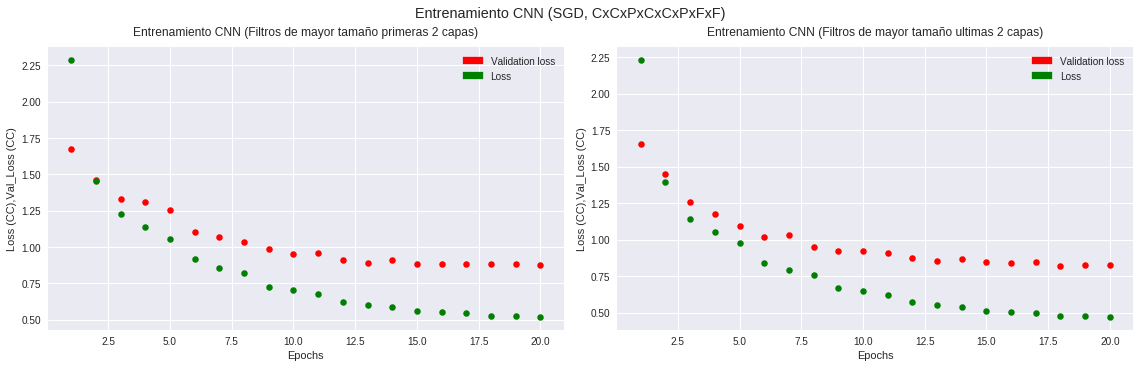

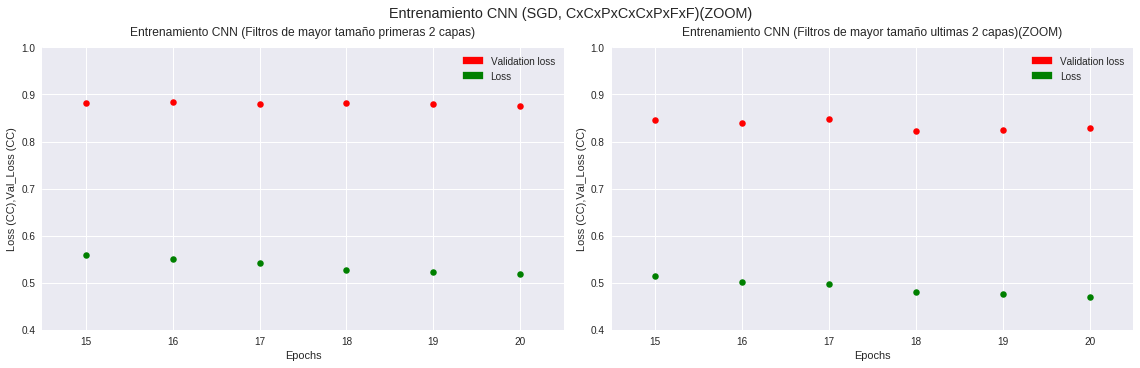

In [310]:
a=np.linspace(1,20,20)
plt.rcParams["figure.figsize"] = [16,5]
plt.title('Entrenamiento CNN (SGD, CxPxCxPxFxF)',y=1.02)
plt.plot(a,hist4.history['val_loss'],'r.',markersize=13)
red=mpatches.Patch(color='red', label='Validation loss')
plt.plot(a,hist4.history['loss'],'g.', markersize=13)
green=mpatches.Patch(color='green', label='Loss')
plt.legend(handles=[red,green])
plt.xlabel('Epochs')
plt.ylabel('Val_Loss, Loss (CC)')
plt.show()

plt.suptitle('Entrenamiento CNN (SGD, CxCxPxCxCxPxFxF)',y=1.02)
plt.subplot(1,2,1)
plt.title('Entrenamiento CNN (Filtros de mayor tamaño primeras 2 capas)',y=1.02)
plt.plot(a,kg[0]['val_loss'],'r.',markersize=13)
red=mpatches.Patch(color='red', label='Validation loss')
plt.plot(a,kg[0]['loss'],'g.', markersize=13)
green=mpatches.Patch(color='green', label='Loss')
plt.legend(handles=[red,green])
plt.xlabel('Epochs')
plt.ylabel('Loss (CC),Val_Loss (CC)')
plt.tight_layout()
plt.subplot(1,2,2)
plt.title('Entrenamiento CNN (Filtros de mayor tamaño ultimas 2 capas)',y=1.02)
plt.plot(a,kg[1]['val_loss'],'r.',markersize=13)
red=mpatches.Patch(color='red', label='Validation loss')
plt.plot(a,kg[1]['loss'],'g.', markersize=13)
green=mpatches.Patch(color='green', label='Loss')
plt.legend(handles=[red,green])
plt.xlabel('Epochs')
plt.ylabel('Loss (CC),Val_Loss (CC)')
plt.tight_layout()
plt.show()

plt.suptitle('Entrenamiento CNN (SGD, CxCxPxCxCxPxFxF)(ZOOM)',y=1.02)
plt.subplot(1,2,1)
plt.title('Entrenamiento CNN (Filtros de mayor tamaño primeras 2 capas)',y=1.02)
plt.plot(a,kg[0]['val_loss'],'r.',markersize=13)
red=mpatches.Patch(color='red', label='Validation loss')
plt.plot(a,kg[0]['loss'],'g.', markersize=13)
green=mpatches.Patch(color='green', label='Loss')
plt.legend(handles=[red,green])
plt.xlabel('Epochs')
plt.ylabel('Loss (CC),Val_Loss (CC)')
plt.xlim([14.5,20.5])
plt.ylim([0.4,1])
plt.tight_layout()
plt.subplot(1,2,2)
plt.title('Entrenamiento CNN (Filtros de mayor tamaño ultimas 2 capas)(ZOOM)',y=1.02)
plt.plot(a,kg[1]['val_loss'],'r.',markersize=13)
red=mpatches.Patch(color='red', label='Validation loss')
plt.plot(a,kg[1]['loss'],'g.', markersize=13)
green=mpatches.Patch(color='green', label='Loss')
plt.legend(handles=[red,green])
plt.xlabel('Epochs')
plt.ylabel('Loss (CC),Val_Loss (CC)')
plt.xlim([14.5,20.5])
plt.ylim([0.4,1])
plt.tight_layout()
plt.show()

*Comentario: Se aprecia que la red presenta un desempeño superior cuando se cuenta con mayor cantidad de capas convolucionales, si bien se cuenta con una mayor cantidad de parámetros aprendibles al tener más capas convolucionales, aumentando la complejidad de la red, es posible evitar el overfitting aplicando un regularizador de peso como se hizo. Es de saber que las primeras capas convolucionales funcionan por lo general como detectores de borde, a medida que se agregan más capas convolucionales estas van encontrando conceptos de mayor nivel de la imágen, es por esto que añadir más capas convolucionales puede ser de una utilidad mayúscula para que la red logre dar con una predicción de mayor calidad sin embargo esto no es generalizable, dado que depende del tipo de imágen que se está analizando y de cómo se llevo a cabo el entrenamiento, durante el pre-proceso donde se intentó obtener mejor desempeño de estas redes sucedió que no se respetaba un orden claro jerárquico desempeños, por lo que lo comentado no es generalizable ya que bien podrían entrenarse estas tres redes con distintos hiperparámetros y obtener resultados distintos a los obtenidos. El añadir filtros de distintos tamaños en distintos niveles de capas se propone para saber si es que a la  red se le hacen más sencillas las tareas de reconocer bordes con filtros chicos y reconocer objetos (conceptos de mayor nivel) con filtros grandes o viceversa, se obtiene que se desempeña levemente mejor al utilizar filtros de menor tamaño al inicio y largos al final.* 

Los errores y accuracy de test asociados son:

In [311]:
print('red CxPxCxPxFxF error y accuracy: '+str(score4)+', '+str(acc4)+'\n')
print('red CxCxPxCxCxPxFxF (filtros de mayor tamaño primeras dos capas) error y accuracy: '+str(sc5[0])+', '+str(ac5[0])+'\n')
print('red CxCxPxCxCxPxFxF (filtros de mayor tamaño últimas dos capas) error y accuracy: '+str(sc5[1])+', '+str(ac5[1]))

red CxPxCxPxFxF error y accuracy: 0.8314819660186767, 0.7392

red CxCxPxCxCxPxFxF (filtros de mayor tamaño primeras dos capas) error y accuracy: 0.8898922222137451, 0.735

red CxCxPxCxCxPxFxF (filtros de mayor tamaño últimas dos capas) error y accuracy: 0.8335322527885437, 0.7481


*Comentario: Se obtienen predicciones de alrededor del 73-75% . En este caso se desempeñó de mejor manera la red profunda con filtros de mayor tamaño en las últimas capas. *

> **h)** Algunos investigadores, han propuesto que las capas de *pooling* se pueden reemplazar por capas convoluciones con stride 2. ¿Se reduce dimensionalidad de este modo? Se investigan los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un *forward-pass*.

Se muestran dos redes las cuales cuentan con la única diferencia de tener una capa convolucional o bien max pooling en la 2da capa.

In [26]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3),strides=(2,2), padding='same'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(10))
model.add(Activation('softmax'))
print(model.summary())

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(10))
model.add(Activation('softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
__________

*Comentario: Se aprecia que al añadir una capa de convolución en lugar de una capa max pooling aporta nuevos parámetros de entrenamiento a la red lo cual no es deseable ya que aumenta la complejidad de la red. Sin embargo se logra dar con un resultado correcto en tanto a la disminución de imagén de 32,32 a 16,16 manteniendo el número de canales para ambos casos, en cambio al ver la totalidad de parámetros se ve que la red convolucional cuenta con 36.928 parámetros más que entrenar, lo cual es una diferencia relativamente pequeña dada la totalidad de parámetros de ambas redes.*

Se procede a entrenar ambas arquitecturas agregando métodos apropiados para evitar el overfitting

In [0]:
from keras.callbacks import LearningRateScheduler, History
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
from keras.optimizers import SGD, rmsprop
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def step_decay(epoch):
    initial_lrate = 0.005
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/4))
    lrate = max(lrate,0.00001)
    return lrate

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3),strides=(2,2), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.35))
model.add(Conv2D(128, (3, 3), padding='same', W_regularizer=l2(0.012)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))
hist6=History()
opt = SGD(lr=0,momentum=0.9)
lrate = LearningRateScheduler(step_decay,verbose=1)
model.compile(opt,loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
history = model.fit(x_train, y_train,epochs=20, validation_data=(x_val,y_val), shuffle=True, callbacks=[hist6,lrate])
score6, acc6 = model.evaluate(x_test, y_test)

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', W_regularizer=l2(0.012)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
hist7=History()
opt = SGD(lr=0,momentum=0.9)
lrate = LearningRateScheduler(step_decay,verbose=1)
model.compile(opt,loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
history = model.fit(x_train, y_train,epochs=20, validation_data=(x_val,y_val), shuffle=True, callbacks=[hist7,lrate])
score7, acc7 = model.evaluate(x_test, y_test)


Se proceden a graficar los resultados obtenidos:

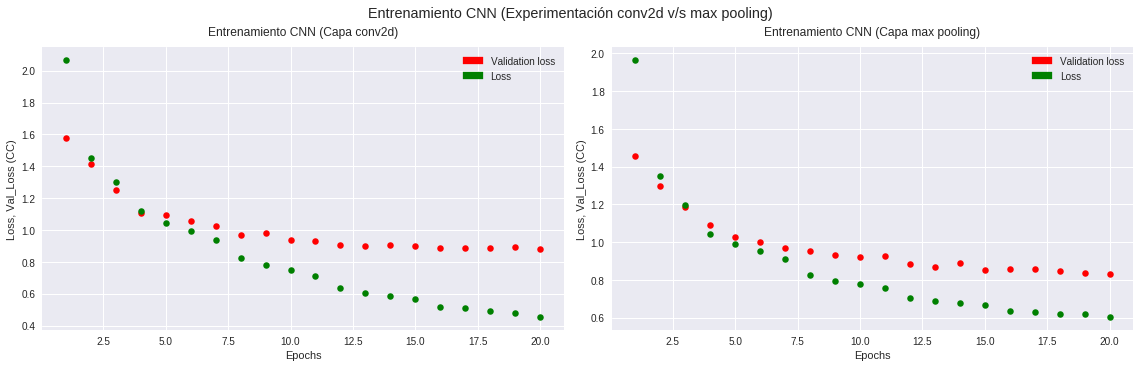

In [19]:
plt.rcParams["figure.figsize"] = [16,5]
a=np.linspace(1,20,20)
plt.suptitle('Entrenamiento CNN (Experimentación conv2d v/s max pooling)',y=1.02)
plt.subplot(1,2,1)
plt.title('Entrenamiento CNN (Capa conv2d)',y=1.02)
plt.plot(a,hist6.history['val_loss'],'r.',markersize=13)
red=mpatches.Patch(color='red', label='Validation loss')
plt.plot(a,hist6.history['loss'],'g.', markersize=13)
green=mpatches.Patch(color='green', label='Loss')
plt.legend(handles=[red,green])
plt.xlabel('Epochs')
plt.ylabel('Loss, Val_Loss (CC)')
plt.tight_layout()
plt.subplot(1,2,2)
plt.title('Entrenamiento CNN (Capa max pooling)',y=1.02)
plt.plot(a,hist7.history['val_loss'],'r.',markersize=13)
red=mpatches.Patch(color='red', label='Validation loss')
plt.plot(a,hist7.history['loss'],'g.', markersize=13)
green=mpatches.Patch(color='green', label='Loss')
plt.legend(handles=[red,green])
plt.xlabel('Epochs')
plt.ylabel('Loss, Val_Loss (CC)')
plt.tight_layout()
plt.show()

*Comentario: Se logra un desempeño mejor utilizando un max pooling en lugar de una capa convolucional, esto es dado que al optar por la capa convolucional el sistema se torna más complejo, esto posiblemente sea reparable aplicando regularizadores de peso o dropout de mejor manera de modo que estos parámetros extra ayuden a la red. Cabe mencionar que la capa convolucional a la vez añade nuevos reconocimientos de características de la imágen que pueden llegar a ser bastante útiles al momento de predecir el conjunto de test, en cambio la capa max pooling tan solamente es usada para disminuir la dimensión del problema haciendo abstracción del input original realizando un mapeo 2x2 sobre la imágen y extrayendo el máximo valor de cada paso de mapeo sobre la matriz de entrada para así reducir la dimensión de entrada de forma relativamente eficaz a la mitad*

El error y accuracy de test fueron los siguientes:

In [20]:
print('red capa conv2d error y accuracy: '+str(score6)+', '+str(acc6))
print('red capa max. pooling error y accuracy: '+str(score7)+', '+str(acc7))

red capa conv2d error y accuracy: 0.8676330256462097, 0.7292
red capa max. pooling error y accuracy: 0.8089523241043091, 0.7445


*Comentario: Manteniéndose así lo afirmado, utilizar la capa max pooling logra un mejor desempeño (en este caso)*

> **i)** Una forma interesante de regularizar modelos entrenados para visión artificial consiste en “aumentar” el número de ejemplos de entrenamiento usando transformaciones sencillas como: rotaciones, corrimientos y reflexiones, tanto horizontales como verticales.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.03125, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.03125, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)

*Comentario: Dado el tipo de imágenes que se busca reconocer se procede a generar imágenes (data augmentation) que cuenten con vueltas horizontales de la imágen pero no vérticales (sería muy extraño contar con imágenes de autos o ciervos de espalda), dada la baja calidad de la imágen (32x32) se realizan desplazamiento verticales y horizontales en un pixel). Se experimentó con variaciones mayores, con zoom y rotaciones obteniéndose peores desempeños.*

Se procede a entrenar la misma red ocupada en **h)** que cuenta con 2 capas convolucionales y dos capas máx pooling.

In [0]:
def step_decay(epoch):
    initial_lrate = 0.005
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/4))
    lrate = max(lrate,0.00001)
    return lrate

model = Sequential()
model.add(Conv2D(64, (5, 5), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), padding='same', W_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
hist8=History()
opt = SGD(lr=0,momentum=0.9)
lrate = LearningRateScheduler(step_decay,verbose=1)
model.compile(opt,loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),steps_per_epoch=x_train.shape[0] // 32, epochs=20,validation_data=(x_val,y_val),callbacks=[hist8,lrate])
score8, acc8 = model.evaluate(x_test, y_test)

Se procede a graficar lo obtenido en comparación con la red sin data augmentation a continuación:

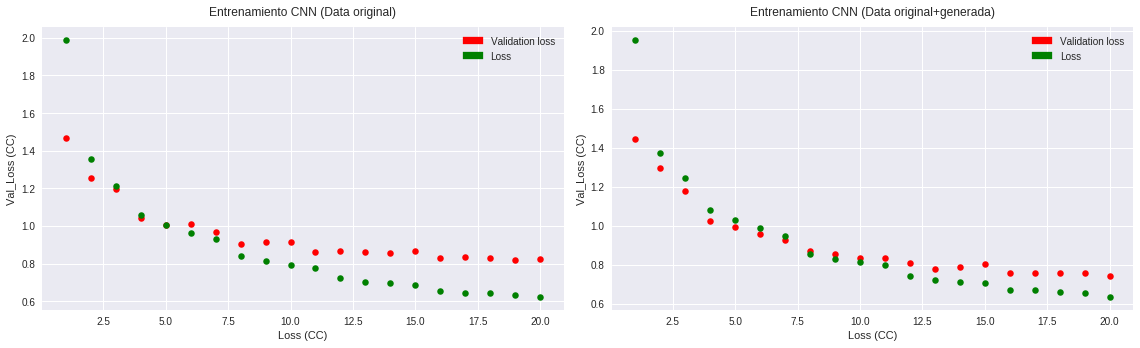

In [86]:
a=np.linspace(1,20,20)
plt.rcParams["figure.figsize"] = [16,5]
plt.subplot(1,2,1)
plt.title('Entrenamiento CNN (Data original)',y=1.02)
plt.plot(a,hist7.history['val_loss'],'r.',markersize=13)
red=mpatches.Patch(color='red', label='Validation loss')
plt.plot(a,hist7.history['loss'],'g.', markersize=13)
green=mpatches.Patch(color='green', label='Loss')
plt.legend(handles=[red,green])
plt.xlabel('Loss (CC)')
plt.ylabel('Val_Loss (CC)')
plt.tight_layout()
plt.subplot(1,2,2)
plt.title('Entrenamiento CNN (Data original+generada)',y=1.02)
plt.plot(a,hist8.history['val_loss'],'r.',markersize=13)
red=mpatches.Patch(color='red', label='Validation loss')
plt.plot(a,hist8.history['loss'],'g.', markersize=13)
green=mpatches.Patch(color='green', label='Loss')
plt.legend(handles=[red,green])
plt.xlabel('Loss (CC)')
plt.ylabel('Val_Loss (CC)')
plt.tight_layout()
plt.show()

*Comentario: Se logra obtener un mejor desempeño de la red al utilizar la técnica de data augmentation.*

Mientras el error y accuracy de test son los siguientes:

In [87]:
print('red capa data original error y accuracy: '+str(score7)+', '+str(acc7))
print('red capa data original + aumentada error y accuracy: '+str(score8)+', '+str(acc8))

red capa data original error y accuracy: 0.8201250697135926, 0.7374
red capa data original + aumentada error y accuracy: 0.7575642490386962, 0.7624


Se mejora el rendimiento en el conjunto de test en un 3%

> **j)** Para una comparación del desempeño de la red neuronal, se pre-procesa el dataset de CIFAR-10 y se calculan los descriptores manuales SIFT.

In [0]:
!pip install opencv-contrib-python==3.4.2.16

In [0]:
import cv2
def pre_process(img):
    if np.max(img) <= 1:
        img*=255
    img = img.astype("uint8")
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img_gray
def calculate_sift(cifar):
    sift_cifar = []
    for image in cifar:
      img_gray = pre_process(image)
      sift = cv2.xfeatures2d.SIFT_create()
      kp, desc = sift.detectAndCompute(img_gray, None)
      if type(desc) == type(None):
        desc = np.zeros((1,128))
      compress_desc = np.mean(desc,axis=0) #compress all keypoints
      sift_cifar.append(compress_desc)
    return np.asarray(sift_cifar)
cifar_sift1 = calculate_sift(x_train)
cifar_sift2 = calculate_sift(x_val)
cifar_sift3 = calculate_sift(x_test)

*Comentario: SIFT ayuda a reconocer puntos clave de las imágenes (keypoints), esto lo realiza calculando los gradientes en la imágen, localizando dónde y en qué sentido se ubica la mayor variación de intensidad, lo cual ayuda a reconocer patrones en imágenes, para realizar esto inicialmente se convierte la imágen a gris, luego la biblioteca cv2 procede internamente a realizar una partición de la imágen en 16 secciones cuadradas, para cada sección se genera un histograma de intensidad de gradiente para cada dirección en sentidos de 8 puntos cardinales (N, NE, E, SE, S, SO, O, NO), luego los histogramas para cada sección se unen obteniéndose un vector de largo 128. La ubicación es entregada por kp mientras su descripción de gradiente es entregada por dc.*

*Una explicación más específica del proceso que sigue es el siguiente: *

*1. Difumina y remuestrea la imágen con distintas escalas de difuminación y proporciones de muestreo para crear un espacio escalado.*

*2. Usa el método de diferencia gaussiana para detectar 'manchas' (blobs) a diferentes escalas, los centros de estas 'manchas' se vuelven los keypoints dados en coordenadas x,y ademas de un valor escalar.*

*3. Asigna a cada keypoint una orientación calculando el histograma de orientaciones de gradientes para cada pixel en su vecindario, escogiendo la orientación con el mayor número de cuentas.*

*4. Brinda invarianza frente el escalamiento y rotación, lo cual es usado para emparejar ocurrencias de ciertas característica en cualquier orientación y escala en un conjunto de imágenes.*


A continuación se grafican los puntos obtenidos, donde los keypoint son encerrados por un circulo donde a mayor radio mayor intensidad, adicionalmente se agrega una línea al círculo que indica el sentido del gradiente.

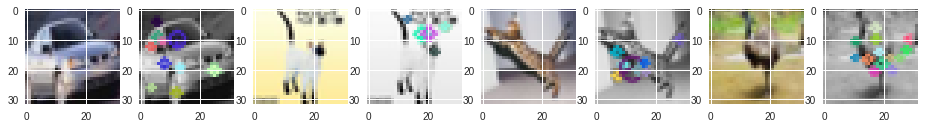

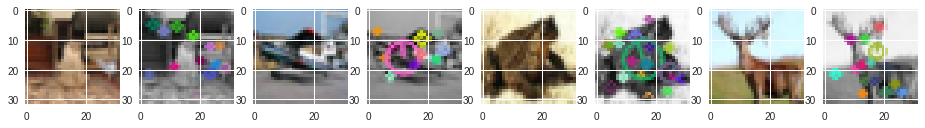

In [123]:
plt.rcParams["figure.figsize"] = [16,5]
def asd(x_train):
  sample_image = x_train
  gray_sample_image = pre_process(sample_image)
  sift = cv2.xfeatures2d.SIFT_create()
  kp = sift.detect(gray_sample_image, None)
  img=cv2.drawKeypoints(gray_sample_image,kp,sample_image,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  return img
for i in range(0,8,2):
  plt.subplot(1,8,i+1)
  plt.imshow(x_train[i]*255)
  plt.subplot(1,8,i+2)
  plt.imshow(asd(x_train[i]))
plt.show()
for i in range(8,16,2):
  plt.subplot(1,8,i-7)
  plt.imshow(x_train[i]*255)
  plt.subplot(1,8,i-6)
  plt.imshow(asd(x_train[i]))
plt.show()

Se procede a comparar los gradientes obtenidos para ranas y gatos a continuación:

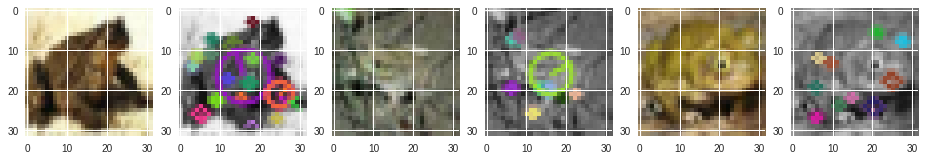

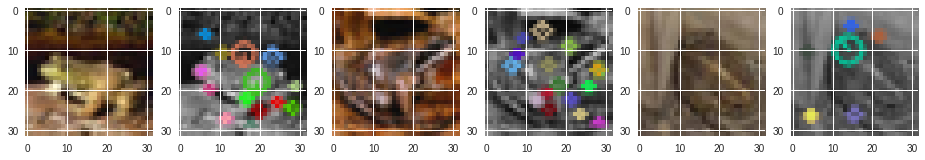

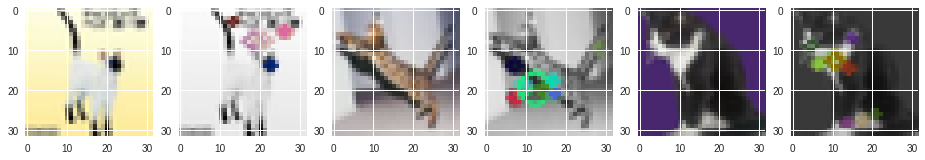

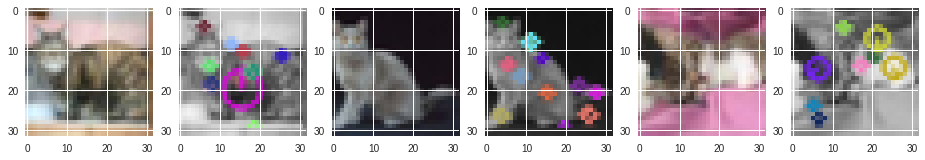

In [156]:
j,k=1,2
for i in [12,16,25]:
  plt.subplot(1,6,j)
  plt.imshow(x_train[i]*255)
  plt.subplot(1,6,k)
  plt.imshow(asd(x_train[i]))
  j+=2
  k+=2
plt.show()
j,k=1,2
for i in [125,153,157]:
  plt.subplot(1,6,j)
  plt.imshow(x_train[i]*255)
  plt.subplot(1,6,k)
  plt.imshow(asd(x_train[i]))
  j+=2
  k+=2
plt.show()
j,k=1,2
for i in [2,4,7]:
  plt.subplot(1,6,j)
  plt.imshow(x_train[i]*255)
  plt.subplot(1,6,k)
  plt.imshow(asd(x_train[i]))
  j+=2
  k+=2
plt.show()
j,k=1,2
for i in [13,62,34]:
  plt.subplot(1,6,j)
  plt.imshow(x_train[i]*255)
  plt.subplot(1,6,k)
  plt.imshow(asd(x_train[i]))
  j+=2
  k+=2
plt.show()



*Comentario: Es posible apreciar que las ranas poseen alta presencia de keypoints a su alrededor mientras los gatos poseen menos consistencia al respecto. Adicionalmente comentar que se ve que el entorno influye en el gradiente, viendo la segunda imágen de gato se ve claramente que los keypoints agarran un alto gradiente a causa de la sombra generada por el gato, no se distingue un patron claro en las imágenes de gato.*

Se procede a entrenar una red neuronal feed forward con la representación en keypoints obtenida

In [0]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/3))
    lrate = max(lrate,0.00001)
    return lrate
hist9 = History()
model = Sequential()
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
opt = SGD(lr=0.0003,decay=1e-06)
model.compile(opt,loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
history = model.fit(cifar_sift1, y_train, epochs=20, verbose=1, validation_data=(cifar_sift2, y_val),callbacks=[hist9])

*Comentario: El entrenamiento de la red es notoriamente más rápido que en las redes anteriores, esto debido a que cuenta con menor cantidad de parámetros que entrenar.*

Se procede a graficar el resultado obtenido

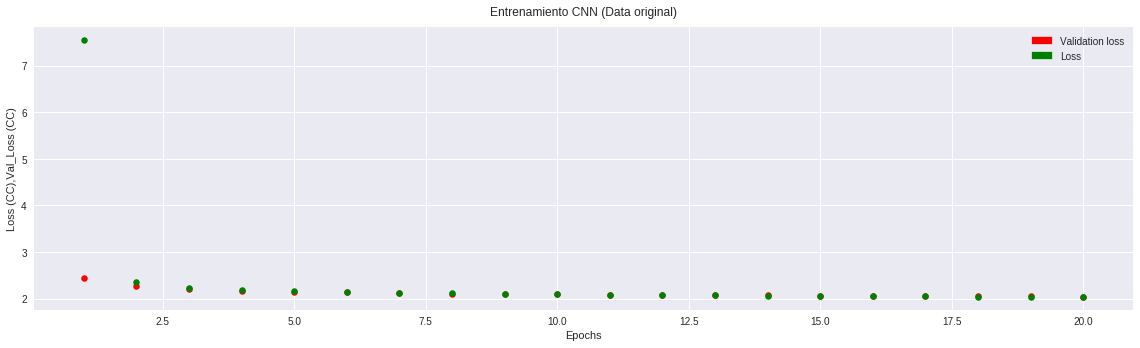

(2, 2.3)

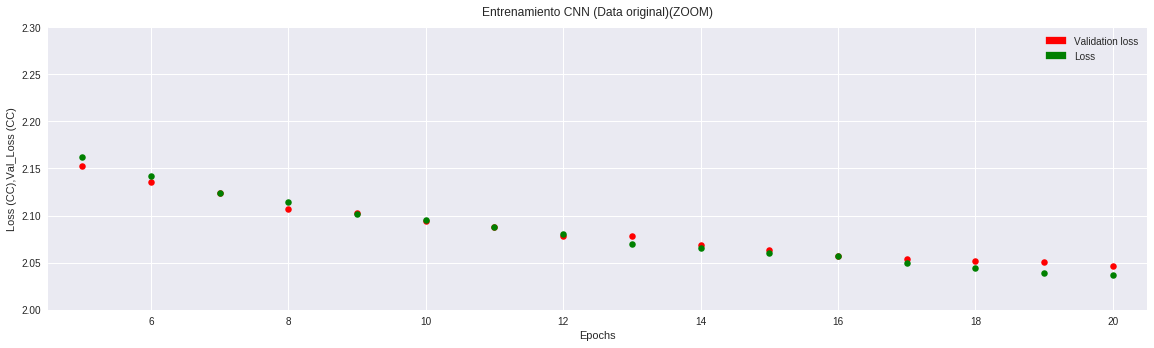

In [216]:
a=np.linspace(1,20,20)
plt.rcParams["figure.figsize"] = [16,5]
plt.title('Entrenamiento CNN (Data original)',y=1.02)
plt.plot(a,hist9.history['val_loss'],'r.',markersize=13)
red=mpatches.Patch(color='red', label='Validation loss')
plt.plot(a,hist9.history['loss'],'g.', markersize=13)
green=mpatches.Patch(color='green', label='Loss')
plt.legend(handles=[red,green])
plt.xlabel('Epochs')
plt.ylabel('Loss (CC),Val_Loss (CC)')
plt.tight_layout()
plt.show()
plt.rcParams["figure.figsize"] = [16,5]
plt.title('Entrenamiento CNN (Data original)(ZOOM)',y=1.02)
plt.plot(a,hist9.history['val_loss'],'r.',markersize=13)
red=mpatches.Patch(color='red', label='Validation loss')
plt.plot(a,hist9.history['loss'],'g.', markersize=13)
green=mpatches.Patch(color='green', label='Loss')
plt.legend(handles=[red,green])
plt.xlabel('Epochs')
plt.ylabel('Loss (CC),Val_Loss (CC)')
plt.tight_layout()
plt.xlim([4.5,20.5])
plt.ylim([2,2.3])

*Comentario: Se obtiene el peor resultado has el momento usando la misma cantidad de epochs y arquitectura de salida de la red (como es sugerido), esto dado que los keypoints no llegan a dar un resultado que ayude claramente a distinguir entre una categoría y otra (p.ej caballo, rana), la descripción del gradiente no es suficiente para este fin.*

El error y accuracy obtenidos al evaluar el conjunto de test son los siguientes

In [218]:
model.evaluate(cifar_sift3, y_test)

10000/10000 [==============================] - 1s 71us/step


[2.0329686058044434, 0.2764]

> **k)** Se procede a entrenar la red de arquitectura CxPxCxPxFxF y se determinan los pares de objetos que la red tiende a confundir. Conjeture el motivo de tal confusión.

In [0]:
def step_decay(epoch):
    initial_lrate = 0.005
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/3))
    lrate = max(lrate,0.00001)
    return lrate
  
hist5 = History()
model = Sequential()
model.add(Conv2D(64, (4,4), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (4,4), padding='same', W_regularizer=l2(0.015)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (4,4), padding='same', W_regularizer=l2(0.015)))
model.add(Activation('relu'))
model.add(Conv2D(128, (4,4), padding='same'))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))
opt = SGD(lr=0,momentum=0.9)
lrate = LearningRateScheduler(step_decay,verbose=1)
model.compile(opt,loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
history = model.fit(x_train, y_train,epochs=20, validation_data=(x_val,y_val), shuffle=True, callbacks=[hist5,lrate])
score5, acc5 = model.evaluate(x_test, y_test)

El error y accuracy de test resulta en:

In [9]:
score5,acc5

(0.8654724355697632, 0.7372)

Se determinan las confusiones de la red para cada predicción, esto se logra encontrando comparando los dos resultados que entrega la red con mayor puntuación.

In [13]:
y=model.predict(x_test)
p1=list()
p2=list()
for i in range(y.shape[0]):
  prediction=label_names[np.argmax(y[i])]
  y[i,np.argmax(y[i])]=0
  prediction2=label_names[np.argmax(y[i])]
  p1.append(prediction)
  p2.append(prediction2)
for j in label_names:
  qwe=list()
  for i in range(y.shape[0]):
    if p1[i]==j:
      qwe.append(p2[i])
  asd=list()
  for i in label_names:
    asd.append(qwe.count(i))
  print('predicción: ',j,'\nconfusión:',label_names[np.argmax(asd)])

predicción:  airplane 
confusión: bird
predicción:  automobile 
confusión: truck
predicción:  bird 
confusión: deer
predicción:  cat 
confusión: dog
predicción:  deer 
confusión: bird
predicción:  dog 
confusión: cat
predicción:  frog 
confusión: cat
predicción:  horse 
confusión: deer
predicción:  ship 
confusión: airplane
predicción:  truck 
confusión: automobile


*Comentario: La raíz de las confusiones no corren para ambas direcciones, es decir la predicción de avión se confunde con pájaros, en cambio los pájaros no se confunden con aviones sino que con venados, esto posiblemente dado que las fotos de aviones tienden a ser cuando están en el cielo (fondo homogéneo) por lo visto en ciertas imágenes del dataset, siendo los pajaros los segundos con mayor predisposición a tener fotos aéreas. Luego la confusión entre autos y camiones es de clara naturaleza, dada la forma de ambos. Confundir pájaros con venados se puede deber a que fotos de ambos suelen ubicarse en el bosque (bien el pájaro puede tener fotos mientras vuela), se reconoce una confusión clara entre animales cuadrípedos, confundir perros y gatos se puede deber además por el hecho de contar con fotos hogareñas. La confusión entre ranas y gatos se puede deber a su naturaleza de ser rayados en su cuerpo. Caballos y venados son bastante parecidos entre sí, aviones y naves también dado su color pseudo homogéneo y ubicación, siendo posible que sea difícil reconocer la diferencia entre cielo y mar.* 

> **l)** Se procede a visualizar los pesos correspondientes a los filtros de la primera y última capa convolucional de la red entrenada. Se visualiza además el efecto del filtro sobre algunas imágenes de entrenamiento. (Nota: La red entrenada en el punto anterior utilizó filtros de tamaño 4x4 para una mejor visualización.)

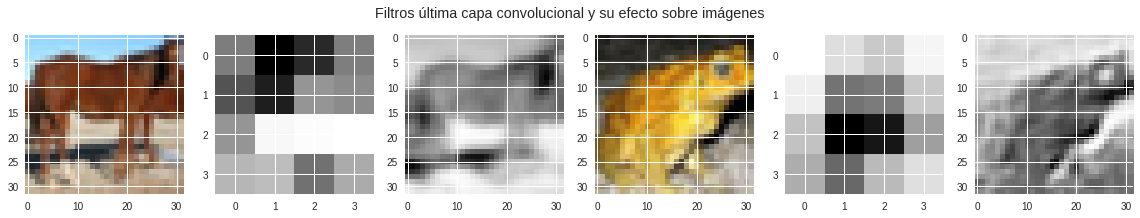

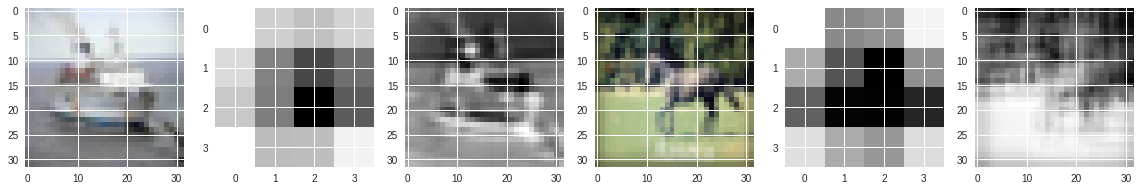

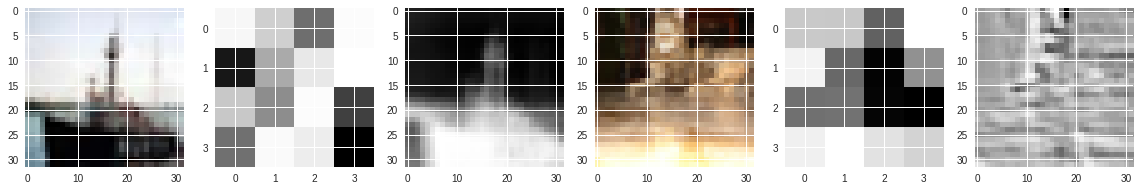

In [24]:
plt.rcParams["figure.figsize"] = [16,5]
from scipy import signal
k=1
s=0
plt.suptitle('Filtros última capa convolucional y su efecto sobre imágenes',y=0.8)
for i in range(6):
  pesoscapa1=model.layers[0].get_weights()[0][:,:,s,:]
  plt.subplot(1,6,k)
  plt.imshow(x_train[i])
  plt.subplot(1,6,k+1)
  plt.imshow(pesoscapa1[:,:,i])
  plt.subplot(1,6,k+2)
  plt.imshow(signal.convolve2d(x_train[i][:,:,s],pesoscapa1[:,:,i], boundary='symm', mode='same'))
  k+=3
  plt.tight_layout()
  if k==7:
    k=1
    s+=1
    plt.show()

*Comentario: Se logran visualizar pesos que gozan de cierta simetría, el primer, segundo y tercer filtro poseen una forma matricial semejante al filtro laplaciano y gaussiano al tener una pseudo forma de cruz estos tres casos pareciesen ayudar al reconocimiento de bordes, en tanto al efecto se ve que por lo general la aplicación de estos filtros terminan por difuminar la imágen.*

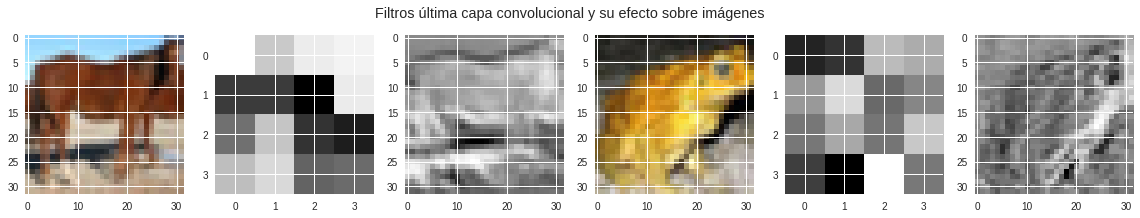

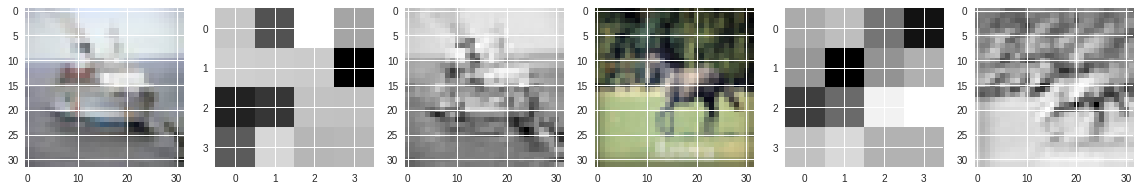

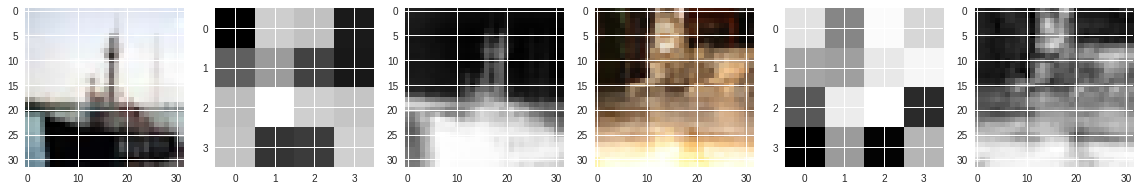

In [18]:
plt.rcParams["figure.figsize"] = [16,5]
k=1
s=0
plt.suptitle('Filtros última capa convolucional y su efecto sobre imágenes',y=0.8)
for i in range(6):
  pesoscapa2=model.layers[9].get_weights()[0][:,:,s,:]
  plt.subplot(1,6,k)
  plt.imshow(x_train[i])
  plt.subplot(1,6,k+1)
  plt.imshow(pesoscapa2[:,:,i])
  plt.subplot(1,6,k+2)
  plt.imshow(signal.convolve2d(x_train[i][:,:,s],pesoscapa2[:,:,i], boundary='symm', mode='same'))
  k+=3
  plt.tight_layout()
  if k==7:
    k=1
    s+=1
    plt.show()

*Comentario: Bien dentro de la red no se aplican los filtros de la última capa convolucional a la imágen directamente se aplican a estas con el fin de ver su efecto. Se ven formas de filtro más complejas que en el caso de la primera capa.*

A continuación se comparan los resultados de aplicar los filtros de cada capa a la misma imágen para una mejor visualización

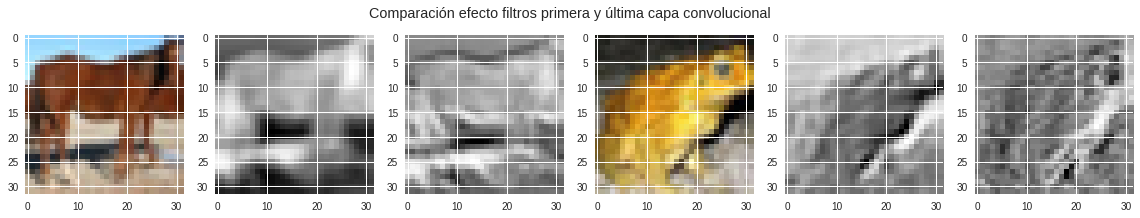

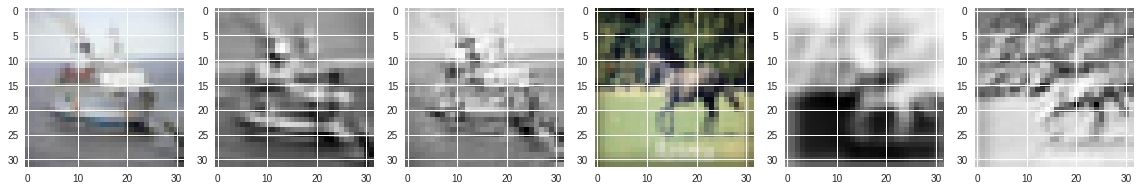

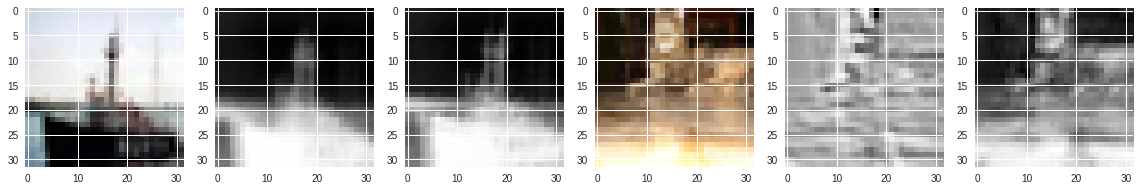

In [25]:
plt.rcParams["figure.figsize"] = [16,5]
k=1
s=0
plt.suptitle('Comparación efecto filtros primera y última capa convolucional',y=0.8)
for i in range(6):
  
  pesoscapa2=model.layers[9].get_weights()[0][:,:,s,:]
  plt.subplot(1,6,k)
  plt.imshow(x_train[i])
  plt.subplot(1,6,k+1)
  plt.imshow(signal.convolve2d(x_train[i][:,:,s],pesoscapa1[:,:,i], boundary='symm', mode='same'))
  plt.subplot(1,6,k+2)
  plt.imshow(signal.convolve2d(x_train[i][:,:,s],pesoscapa2[:,:,i], boundary='symm', mode='same'))
  k+=3
  plt.tight_layout()
  if k==7:
    k=1
    s+=1
    plt.show()

*Comentario: Se ve que los filtros de la última capa resultan en una imágen menos difuminada que los de la primera capa, siendo más fácil reconocer los animales/objetos dentro de la imágen, esto debido a su naturaleza más compleja. Se ve que los resultados entregan información mucho más enriquecedoras que las obtenidas por medio del método SIFT, donde contar sólo con el gradiente de la imágen no ha llevado a servir para lograr una buena predicción, esto también posible debido a la baja resolución de las imágenes, donde la transición de un pixel a otro abarca un área relativamente grande de la imágen.*

## 2. *Transfer Learning*

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/05/31130754/transfer-learning.jpeg" , style="float: right;" />

En esta sección se trabajará con el dataset trabajado anteriormente, CIFAR, pero en su versión más fina, en el cual se presentan 100 tipos distintos de categorías a clasificar la imagen (mutuamente excluyentes), no 10 como se usó en las actividades anteriores. La estructura es la misma, son 60000 imágenes RGB de 32 $\times$ 32 píxeles separados en 50 mil de entrenamiento y 10 mil de pruebas.  

Se procede a obtener el conjunto de entrenamiento y test desde el dataset CIFAR100

In [0]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

169009152/169001437 [==============================] - 63s 0us/step


Se Normaliza entre [0,1] el vector de entrada y se transforman el vector de salida en un hot vector.

In [0]:
import keras
y_train = keras.utils.to_categorical(y_train, num_classes=100)
y_test = keras.utils.to_categorical(y_test, num_classes=100)
x_train_norm = x_train/255.0
x_test_norm = x_test/255.0

In [0]:
x_test.shape

(10000, 32, 32, 3)

> **a)** Se entrena una red neuronal convolucional como se presenta en el código a continuación durante 15 epochs, realizando un gráfico de evolución de la función de pérdida y de la exactitud del algoritmo (accuracy) sobre ambos conjuntos, entrenamiento y pruebas. Comente sobre el tiempo de ejecución de este entrenamiento. Reporte el accuracy del modelo final sobre el conjunto de pruebas.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import History 
from keras import metrics
import matplotlib.pyplot as plt
eps=15
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
optimizer_= SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy']) 
seqModel1=model.fit(x_train_norm, y_train, batch_size=128,epochs=eps,verbose=1, validation_data=(x_test_norm,y_test)) 
model.summary()



Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 16s 329us/step - loss: 4.2849 - acc: 0.0534 - val_loss: 3.8080 - val_acc: 0.1220
Epoch 2/15
50000/50000 [==============================] - 12s 238us/step - loss: 3.7677 - acc: 0.1292 - val_loss: 3.5493 - val_acc: 0.1686
Epoch 3/15
50000/50000 [==============================] - 12s 237us/step - loss: 3.4367 - acc: 0.1849 - val_loss: 3.1452 - val_acc: 0.2460
Epoch 4/15
50000/50000 [==============================] - 12s 239us/step - loss: 3.1084 - acc: 0.2430 - val_loss: 2.9581 - val_acc: 0.2823
Epoch 5/15
50000/50000 [==============================] - 12s 238us/step - loss: 2.8331 - acc: 0.2970 - val_loss: 2.6881 - val_acc: 0.3311
Epoch 6/15
50000/50000 [==============================] - 12s 238us/step - loss: 2.5999 - acc: 0.3445 - val_loss: 2.6294 - val_acc: 0.3449
Epoch 7/15
50000/50000 [==============================] - 12s 238us/step - loss: 2.3763 - acc: 0.3891 - val_loss: 2.

*Comentario: Se entrena la red con un learning rate reducido como es lo recomendable en transfer learning. El entrenamiento de la red toma 12 segundos por epoch con aproximadamente 4 millones de parámetros entrenables y un batchsize de 128 lo cual es relativamente lento comparado con lo que se puede obtener en los siguientes items.*

Se obtienen los siguientes accuracy con respecto al conjunto de entrenamiento y validación al final del entrenamiento 

In [0]:
train_acc  = seqModel1.history['acc']
val_acc    = seqModel1.history['val_acc']
print('train_acc, epoch 15:')
print(train_acc[14])

print('val_acc, epoch 15:')
print(val_acc[14])

train_acc, epoch 15:
0.715959999961853
val_acc, epoch 15:
0.4176


El resultado obtenido es relativamente bajo, obteniéndose un 41% sobre el conjunto de validación.

Se procede a graficar la evolución de los errores y accuracy de entrenamiento y validación.

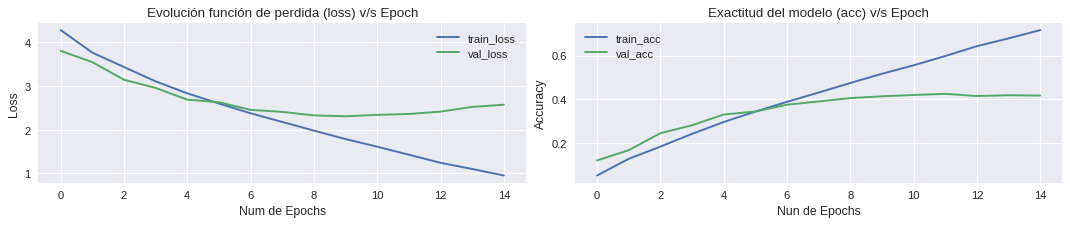

In [0]:
eps1=15
train_loss1 = seqModel1.history['loss']
val_loss1   = seqModel1.history['val_loss']
train_acc1  = seqModel1.history['acc']
val_acc1    = seqModel1.history['val_acc']
xc1         = range(eps)

plt.figure()
plt.figure(figsize=(8,2), dpi=80)
plt.subplot(1,2,1)
plt.plot(xc1,train_loss1 ,label = "train_loss")
plt.plot(xc1, val_loss1,label = "val_loss")
plt.legend(loc='upper right')
plt.title('Evolución función de perdida (loss) v/s Epoch')
plt.xlabel('Num de Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(xc1,train_acc1 ,label = "train_acc")
plt.plot(xc1, val_acc1 ,label = "val_acc")
plt.legend(loc='upper left')
plt.title('Exactitud del modelo (acc) v/s Epoch')
plt.xlabel('Nun de Epochs')
plt.ylabel('Accuracy')

plt.subplots_adjust(top=4, bottom=3, left=0.4, right=2, hspace=1.2,
                    wspace=0.1)
plt.show()


*Comentarios: Se logra visualizar un overfitting respecto al error de validación luego del epoch 8, sin embargo se ve que el accuracy de validación empieza a empeorar recién en el epoch número 11*

**b)** Debido al comportamiento de las curvas de entrenamiento, claramente se ve que se necesita un regularizador. Se experimenta utilizando Dropout con una tasa de 0.25 en las tandas convolucionales

Se procede a experimentar con la variación de la ubicación del dropout dentro de la red convolucional

In [0]:
eps=15
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
optimizer_= SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy']) 
seqModel2=model.fit(x_train_norm, y_train, batch_size=128,epochs=eps,verbose=0, validation_data=(x_test_norm,y_test)) 
model.summary()

eps=15
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
optimizer_= SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy']) 
seqModel3=model.fit(x_train_norm, y_train, batch_size=128,epochs=eps,verbose=0, validation_data=(x_test_norm,y_test)) 
model.summary()

eps=15
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
optimizer_= SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy']) 
seqModel4=model.fit(x_train_norm, y_train, batch_size=128,epochs=eps,verbose=0, validation_data=(x_test_norm,y_test)) 
model.summary()

eps=15
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
optimizer_= SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy']) 
seqModel5=model.fit(x_train_norm, y_train, batch_size=128,epochs=eps,verbose=0, validation_data=(x_test_norm,y_test)) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
__________

Se grafican los resultados obtenidos

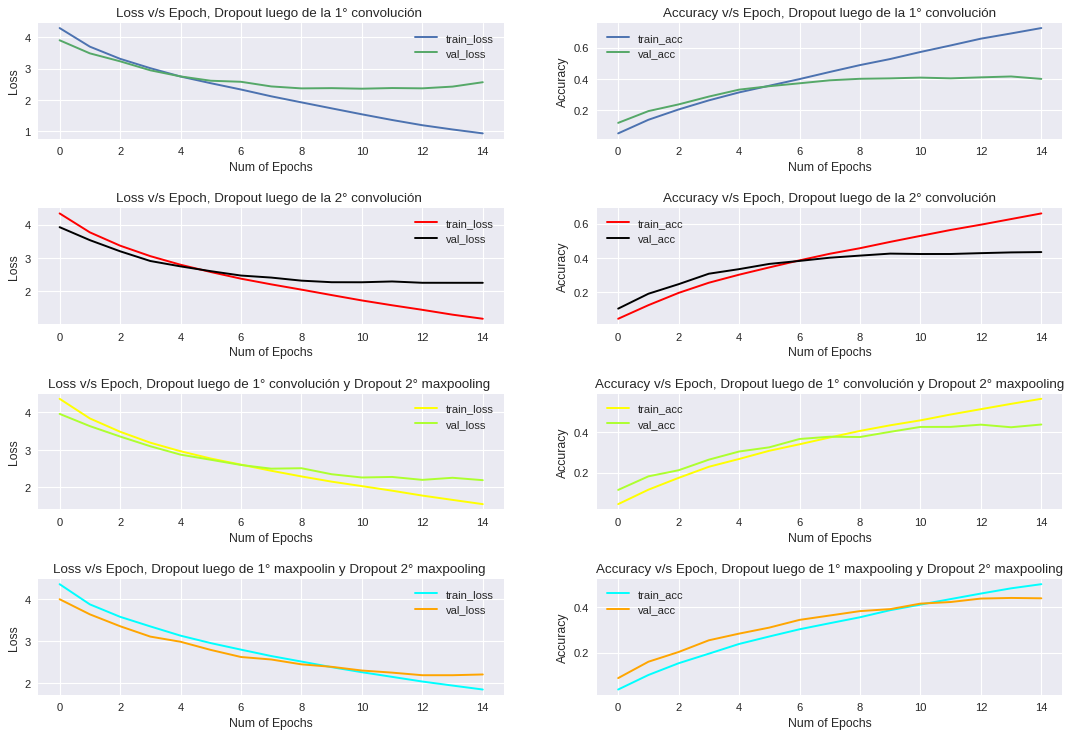

In [0]:
eps2=15
train_loss2 = seqModel2.history['loss']
val_loss2   = seqModel2.history['val_loss']
train_acc2  = seqModel2.history['acc']
val_acc2    = seqModel2.history['val_acc']
xc2         = range(eps2)

train_loss3 = seqModel3.history['loss']
val_loss3   = seqModel3.history['val_loss']
train_acc3  = seqModel3.history['acc']
val_acc3    = seqModel3.history['val_acc']
xc3         = range(eps2)

train_loss4 = seqModel4.history['loss']
val_loss4   = seqModel4.history['val_loss']
train_acc4  = seqModel4.history['acc']
val_acc4    = seqModel4.history['val_acc']
xc4         = range(eps2)

train_loss5 = seqModel5.history['loss']
val_loss5   = seqModel5.history['val_loss']
train_acc5  = seqModel5.history['acc']
val_acc5    = seqModel5.history['val_acc']
xc5         = range(eps2)

plt.figure()

plt.figure(figsize=(8,2), dpi=80)

plt.subplot(4,2,1)
plt.plot(xc2,train_loss2 ,label = "train_loss")
plt.plot(xc2, val_loss2,label = "val_loss")
plt.legend(loc='upper right')
plt.title('Loss v/s Epoch, Dropout luego de la 1° convolución ')
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')

plt.subplot(4,2,3)
plt.plot(xc3,train_loss3 ,'r',label = "train_loss")
plt.plot(xc3, val_loss3,'k',label = "val_loss")
plt.legend(loc='upper right')
plt.title('Loss v/s Epoch, Dropout luego de la 2° convolución ')
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')

plt.subplot(4,2,5)
plt.plot(xc4,train_loss4 ,'yellow',label = "train_loss")
plt.plot(xc4, val_loss4,'greenyellow',label = "val_loss")
plt.legend(loc='upper right')
plt.title('Loss v/s Epoch, Dropout luego de 1° convolución y Dropout 2° maxpooling ')
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')

plt.subplot(4,2,7)
plt.plot(xc5,train_loss5 ,'aqua',label = "train_loss")
plt.plot(xc5, val_loss5,'orange',label = "val_loss")
plt.legend(loc='upper right')
plt.title('Loss v/s Epoch, Dropout luego de 1° maxpoolin y Dropout 2° maxpooling ')
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')

plt.subplot(4,2,2)
plt.plot(xc2,train_acc2 ,label = "train_acc")
plt.plot(xc2, val_acc2 ,label = "val_acc")
plt.legend(loc='upper left')
plt.title('Accuracy v/s Epoch, Dropout luego de la 1° convolución')
plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy')

plt.subplot(4,2,4)
plt.plot(xc3,train_acc3 ,'r',label = "train_acc")
plt.plot(xc3, val_acc3 ,'k',label = "val_acc")
plt.legend(loc='upper left')
plt.title('Accuracy v/s Epoch, Dropout luego de la 2° convolución')
plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy')

plt.subplot(4,2,6)
plt.plot(xc4,train_acc4 ,'yellow',label = "train_acc")
plt.plot(xc4, val_acc4 ,'greenyellow',label = "val_acc")
plt.legend(loc='upper left')
plt.title('Accuracy v/s Epoch, Dropout luego de 1° convolución y Dropout 2° maxpooling')
plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy')

plt.subplot(4,2,8)
plt.plot(xc5,train_acc5 ,'aqua',label = "train_acc")
plt.plot(xc5, val_acc5 ,'orange',label = "val_acc")
plt.legend(loc='upper left')
plt.title('Accuracy v/s Epoch, Dropout luego de 1° maxpooling y Dropout 2° maxpooling')
plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy')

plt.subplots_adjust(top=6, bottom=1.8, left=0.4, right=2, hspace=0.6,
                    wspace=0.2)


plt.show()


*Comentarios: Se obtiene un mejor comportamiento al ocupar dropout luego del primer y segundo maxpooling respecto al accuracy, adicionalmente se logra exitosamente enfrentar el overfitting presente en el item anterior usando la misma red*

**c)** Una forma de hacer lo que se conoce como transfer learning es utilizar el conocimiento (los parámetros) aprendido por una red entrenada con millones de imágenes, y tomar estos parámetros como los pre entrenados. Para esto se utilizará el modelo VGG16 proporcionado a través de la interfaz de keras.

Se procede a cargar el modelo a utilizar y a visualizar las 32 capas que lo componen

In [0]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dropout, Flatten, Dense, Input
x_train_vgg = preprocess_input(x_train)
x_test_vgg = preprocess_input(x_test)
input_tensor=Input(shape=x_train_vgg.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor ) # LOAD PRETRAINED MODEL 
features_train = modelVGG.predict(x_train_vgg)
features_test = modelVGG.predict(x_test_vgg)
modelVGG.summary()


58892288/58889256 [==============================] - 10s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_poo

Se aplica adicionalmente un preprocesamiento de los datos de entrada de entrenamiento y validación para que sean aceptados por la red, se obtiene la siguiente forma luego de pasar la entrada del dataset de entrenamiento por la red, es decir a la salida del último max pooling de la red convolucional.

In [0]:
features_train.shape

(50000, 1, 1, 512)

Se hace necesario añadir a este modelo capas densas para obtener la salida requerida, esto se realiza en el siguiente ítem.

**d)** Se procede a entrenar esta red agregando una capa densa de 1024 neuronas seguido de un dropout de 0.5, finalmente es necesario agregar la capa de clasificación para las 100 clases. Se utiliza la misma configuración del optimizador para que las comparaciones sean válidas.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import metrics
import matplotlib.pyplot as plt
eps=10
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
optimizer_= SGD(lr=0.01,momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
seqModel6=model.fit(features_train, y_train,epochs=eps, batch_size=128,verbose=1,validation_data=(features_test,y_test))
model.summary()


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2s 49us/step - loss: 14.8922 - acc: 0.0702 - val_loss: 14.8113 - val_acc: 0.0789
Epoch 2/10
50000/50000 [==============================] - 2s 41us/step - loss: 14.7962 - acc: 0.0804 - val_loss: 14.7043 - val_acc: 0.0866
Epoch 3/10
50000/50000 [==============================] - 2s 42us/step - loss: 14.7628 - acc: 0.0830 - val_loss: 14.6396 - val_acc: 0.0905
Epoch 4/10
50000/50000 [==============================] - 2s 42us/step - loss: 14.7154 - acc: 0.0860 - val_loss: 14.6677 - val_acc: 0.0893
Epoch 5/10
50000/50000 [==============================] - 2s 42us/step - loss: 14.7538 - acc: 0.0841 - val_loss: 14.6737 - val_acc: 0.0889
Epoch 6/10
50000/50000 [==============================] - 2s 43us/step - loss: 14.7279 - acc: 0.0856 - val_loss: 14.6448 - val_acc: 0.0911
Epoch 7/10
50000/50000 [==============================] - 2s 42us/step - loss: 14.7506 - acc: 0.0844 - val_loss: 14.

*Comentario: El tiempo de entrenamiento se ve reducido a 2 segundos dado que se entrena tan solamente la red neuronal feed forward al final de la red convolucional ya adquirida*

Se procede a graficar lo obtenido comparando con lo obtenido en ítems anteriores

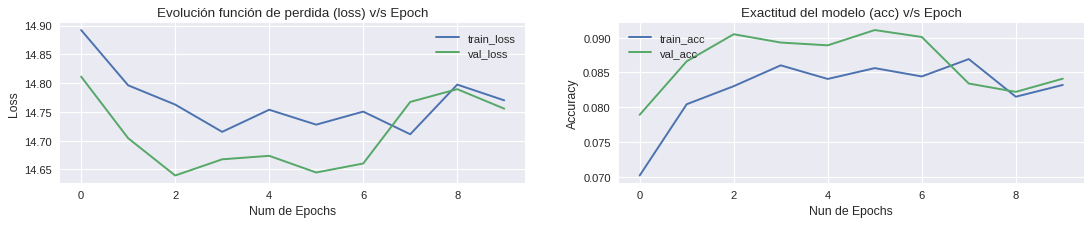

In [0]:
eps6=10
train_loss6 = seqModel6.history['loss']
val_loss6   = seqModel6.history['val_loss']
train_acc6  = seqModel6.history['acc']
val_acc6    = seqModel6.history['val_acc']
xc6         = range(eps6)

plt.figure()
#plt.rcParams["figure.figsize"] = [9,6]
plt.figure(figsize=(8,2), dpi=80)
plt.subplot(1,2,1)
plt.plot(xc6,train_loss6 ,label = "train_loss")
plt.plot(xc6, val_loss6,label = "val_loss")

plt.legend(loc='upper right')
plt.title('Evolución función de perdida (loss) v/s Epoch')
plt.xlabel('Num de Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(xc6,train_acc6 ,label = "train_acc")
plt.plot(xc6, val_acc6 ,label = "val_acc")
plt.legend(loc='upper left')
plt.title('Exactitud del modelo (acc) v/s Epoch')
plt.xlabel('Nun de Epochs')
plt.ylabel('Accuracy')

plt.subplots_adjust(top=4, bottom=3, left=0.4, right=2, hspace=1.2,
                    wspace=0.2)
plt.show()

*Comentario: Se obtiene un comportamiento errático de la red, viéndose que se inicia con unknown fitting que es resuelto en el epoch número 7 para luego volver a otro uknown fitting menor en el epoch número 9. Adicionalmente hay un error relativamente grande y un accuracy realmente pequeño.*

**Compración con modelos anteriores:**

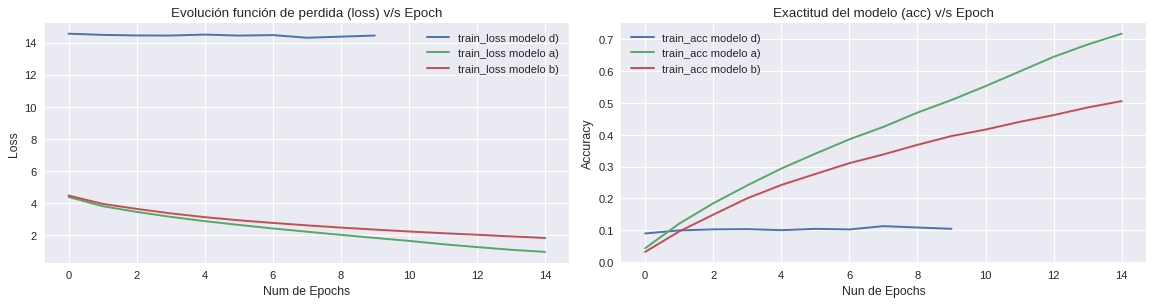

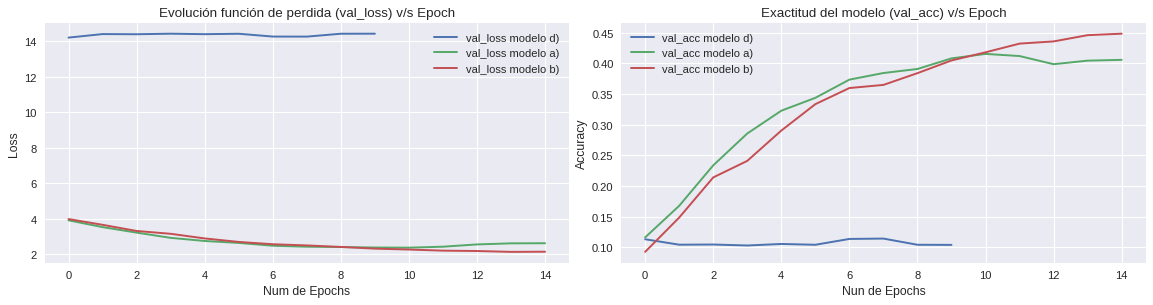

In [24]:
plt.figure()
plt.figure(figsize=(8.6,3), dpi=80)
plt.subplot(1,2,1)
plt.plot(xc6,train_loss6 ,label = "train_loss modelo d)")
plt.plot(xc1,train_loss1 ,label = "train_loss modelo a)")
plt.plot(xc5,train_loss5 ,label = "train_loss modelo b)")
plt.legend(loc='upper right')
plt.title('Evolución función de perdida (loss) v/s Epoch')
plt.xlabel('Num de Epochs')
plt.ylabel('Loss')


plt.subplot(1,2,2)
plt.plot(xc6,train_acc6 ,label = "train_acc modelo d)")
plt.plot(xc1,train_acc1 ,label = "train_acc modelo a)")
plt.plot(xc5,train_acc5 ,label = "train_acc modelo b)")
plt.legend(loc='upper left')
plt.title('Exactitud del modelo (acc) v/s Epoch')
plt.xlabel('Nun de Epochs')
plt.ylabel('Accuracy')

plt.subplots_adjust(top=4, bottom=3, left=0.4, right=2, hspace=1.2,
                    wspace=0.1)
plt.show()

plt.figure()
plt.figure(figsize=(8.6,3), dpi=80)
plt.subplot(1,2,1)
plt.plot(xc6,val_loss6 ,label = "val_loss modelo d)")
plt.plot(xc1,val_loss1 ,label = "val_loss modelo a)")
plt.plot(xc5,val_loss5 ,label = "val_loss modelo b)")
plt.legend(loc='upper right')
plt.title('Evolución función de perdida (val_loss) v/s Epoch')
plt.xlabel('Num de Epochs')
plt.ylabel('Loss')


plt.subplot(1,2,2)
plt.plot(xc6,val_acc6 ,label = "val_acc modelo d)")
plt.plot(xc1,val_acc1 ,label = "val_acc modelo a)")
plt.plot(xc5,val_acc5 ,label = "val_acc modelo b)")
plt.legend(loc='upper left')
plt.title('Exactitud del modelo (val_acc) v/s Epoch')
plt.xlabel('Nun de Epochs')
plt.ylabel('Accuracy')

plt.subplots_adjust(top=4, bottom=3, left=0.4, right=2, hspace=1.2,
                    wspace=0.1)
plt.show()


*Comentario: En items anteriores se obtiene un mejor aprendizaje de la red respecto al loss de entrenamiento, donde se puede ver que se evoluciona correctamente a lo largo de los epochs tanto en el modelo a) y b), sin embargo esto no se logro con la red adquerida (modelo d)) donde comparativamente hablando se ve que se obtiene un comportamiento inferior tanto en el conjunto de entrenamiento como de validación.*

**e)** Se procede a agregar una capa de normalización (Batch Normalization) de las activaciones en las capas densas, esto es, restar por la media del batch y dividir por la desviación estándar. Se vuelve a entrenar el modelo con la misma configuración pero ahora por 15 epochs.

In [0]:
from keras.layers.normalization import BatchNormalization
eps=15
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
optimizer_= SGD(lr=0.01,momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
seqModel7=model.fit(features_train, y_train,epochs=eps, batch_size=128,verbose=1,validation_data=(features_test,y_test))
model.summary()

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 4s 83us/step - loss: 3.3110 - acc: 0.2698 - val_loss: 2.4228 - val_acc: 0.3932
Epoch 2/15
50000/50000 [==============================] - 3s 67us/step - loss: 2.4850 - acc: 0.3737 - val_loss: 2.3156 - val_acc: 0.4096
Epoch 3/15
50000/50000 [==============================] - 3s 67us/step - loss: 2.2505 - acc: 0.4142 - val_loss: 2.2572 - val_acc: 0.4210
Epoch 4/15
50000/50000 [==============================] - 3s 68us/step - loss: 2.1188 - acc: 0.4385 - val_loss: 2.2202 - val_acc: 0.4254
Epoch 5/15
50000/50000 [==============================] - 3s 67us/step - loss: 2.0151 - acc: 0.4590 - val_loss: 2.2097 - val_acc: 0.4293
Epoch 6/15
50000/50000 [==============================] - 3s 68us/step - loss: 1.9391 - acc: 0.4713 - val_loss: 2.2002 - val_acc: 0.4309
Epoch 7/15
50000/50000 [==============================] - 3s 67us/step - loss: 1.8539 - acc: 0.4900 - val_loss: 2.2041 - val_acc

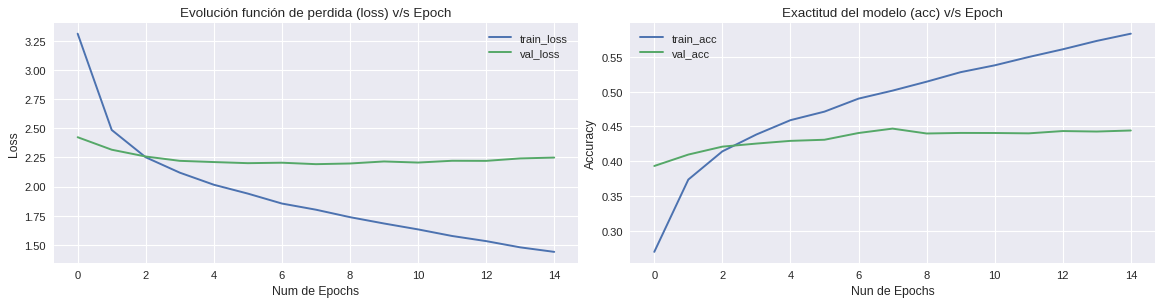

In [0]:
eps7=15
train_loss7 = seqModel7.history['loss']
val_loss7   = seqModel7.history['val_loss']
train_acc7  = seqModel7.history['acc']
val_acc7    = seqModel7.history['val_acc']
xc7         = range(eps7)

plt.figure()
plt.figure(figsize=(8.6,3), dpi=80)
plt.subplot(1,2,1)
plt.plot(xc7,train_loss7 ,label = "train_loss")
plt.plot(xc7, val_loss7,label = "val_loss")
plt.legend(loc='upper right')
plt.title('Evolución función de perdida (loss) v/s Epoch')
plt.xlabel('Num de Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(xc7,train_acc7 ,label = "train_acc")
plt.plot(xc7, val_acc7 ,label = "val_acc")
plt.legend(loc='upper left')
plt.title('Exactitud del modelo (acc) v/s Epoch')
plt.xlabel('Nun de Epochs')
plt.ylabel('Accuracy')

plt.subplots_adjust(top=4, bottom=3, left=0.4, right=2, hspace=1.2,
                    wspace=0.1)
plt.show()

*Comentario: Se mejora notablemente el comportamiento previo al aplicar batch normalization, lográndose errores menores y de evolución deseada, sin embargo, se presenta un overfitting respecto a la validación en el epoch 7 lográndose a la vez el mejor accuracy en este mismo epoch.*

**Comparación con modelos anteriores:**

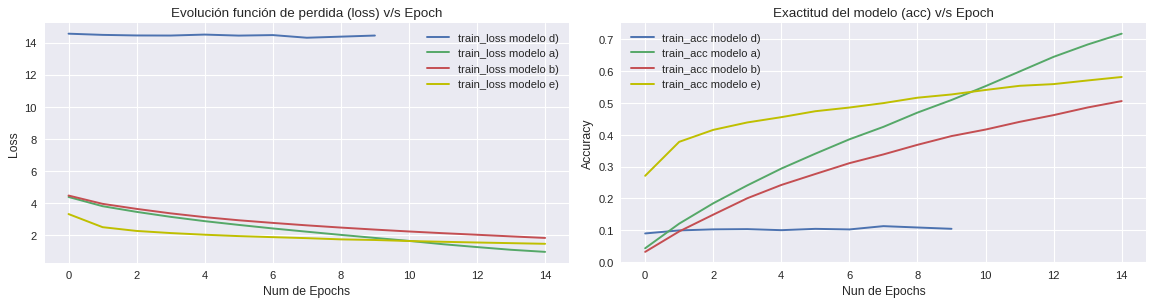

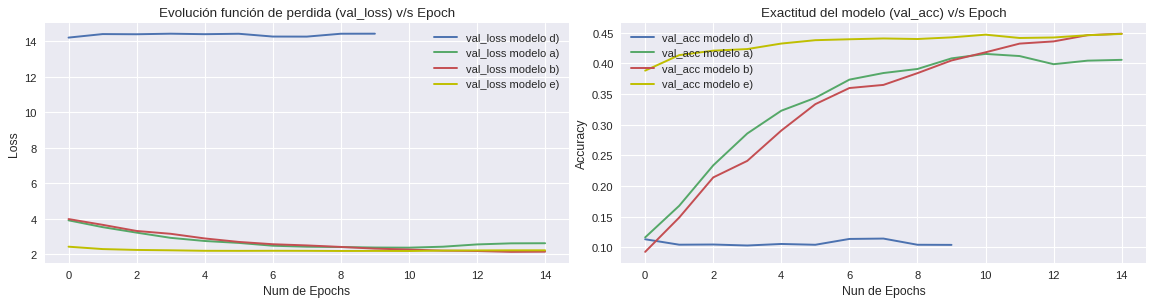

In [25]:
plt.figure()
plt.figure(figsize=(8.6,3), dpi=80)
plt.subplot(1,2,1)
plt.plot(xc6,train_loss6 ,label = "train_loss modelo d)")
plt.plot(xc1,train_loss1 ,label = "train_loss modelo a)")
plt.plot(xc5,train_loss5 ,label = "train_loss modelo b)")
plt.plot(xc7,train_loss7 ,'y',label = "train_loss modelo e)")
plt.legend(loc='upper right')
plt.title('Evolución función de perdida (loss) v/s Epoch')
plt.xlabel('Num de Epochs')
plt.ylabel('Loss')


plt.subplot(1,2,2)
plt.plot(xc6,train_acc6 ,label = "train_acc modelo d)")
plt.plot(xc1,train_acc1 ,label = "train_acc modelo a)")
plt.plot(xc5,train_acc5 ,label = "train_acc modelo b)")
plt.plot(xc7,train_acc7 ,'y',label = "train_acc modelo e)")
plt.legend(loc='upper left')
plt.title('Exactitud del modelo (acc) v/s Epoch')
plt.xlabel('Nun de Epochs')
plt.ylabel('Accuracy')

plt.subplots_adjust(top=4, bottom=3, left=0.4, right=2, hspace=1.2,
                    wspace=0.1)
plt.show()

plt.figure()
plt.figure(figsize=(8.6,3), dpi=80)
plt.subplot(1,2,1)
plt.plot(xc6,val_loss6 ,label = "val_loss modelo d)")
plt.plot(xc1,val_loss1 ,label = "val_loss modelo a)")
plt.plot(xc5,val_loss5 ,label = "val_loss modelo b)")
plt.plot(xc7,val_loss7 ,'y',label = "val_loss modelo e)")
plt.legend(loc='upper right')
plt.title('Evolución función de perdida (val_loss) v/s Epoch')
plt.xlabel('Num de Epochs')
plt.ylabel('Loss')


plt.subplot(1,2,2)
plt.plot(xc6,val_acc6 ,label = "val_acc modelo d)")
plt.plot(xc1,val_acc1 ,label = "val_acc modelo a)")
plt.plot(xc5,val_acc5 ,label = "val_acc modelo b)")
plt.plot(xc7,val_acc7 ,'y',label = "val_acc modelo e)")
plt.legend(loc='upper left')
plt.title('Exactitud del modelo (val_acc) v/s Epoch')
plt.xlabel('Nun de Epochs')
plt.ylabel('Accuracy')

plt.subplots_adjust(top=4, bottom=3, left=0.4, right=2, hspace=1.2,
                    wspace=0.1)
plt.show()


*Comentario: Se obtiene un comportamiento de calidad semejante a los modelos a) y b) respecto al error de entrenamiento, sin embargo no se obtienen mejores resultados, esto podría ser mejorado por medio de técnicas de entrenamiento que ayuden a la red a desarrollarse de mejor forma, bien se puede hacer un listado sin fin de técnicas a utilizar que podrían resultar en un modelo superior al obtenido en a) y en b). Respecto al accuracy de validación  se obtiene un valor equivalente al obtenido al modelo b). Adicionalmente se aprecia que al aplicar batch normalization el tiempo de ejecución se torna más lento en aproximadamente un segundo por epoch. *

> g) ¿Cuándo podría ser útil y cuando no utilizar *transfer learning* o una red pre-entrenada?

Se torna útil ocupar transfer learning cuando se cuenta con una red pre-entrenada con un gran data-set de imágenes similares a las que se requieren clasificar, a la vez se requiere que tenga como fin obtener clasificaciones semejantes a las que se desean obtener, bien si se cuenta con una red que es entrenada para que a partir de imágenes de perros y gatos obtenga una clasificación del color de sus ojos entraría a ser discutible si utilizarla o no si se requieren clasificar las imágenes en razas de perros y gatos, sería realmente poco útil utilizar una red que no cuente con un dataset de entrada que no tenga relación con el que se requiere utilizar para clasificación. Es claro que la red obtenida rara vez va a obtener un data set de entrada y salida coherente con la red que se busca diseñar, por lo que se hace necesario re-entrenar a la red para obtener un mejor comportamiento como es que se hizo en el ítem **e)**.

<a id="cuarto"></a>
## 3. CNN sobre texto

Cuando oímos sobre redes neuronales convolucionales (CNN) normalmente pensamos en visión artificial. Las CNN fueron responsables de los principales avances en la clasificación de imágenes y son el núcleo de la mayoría de los sistemas de *Computer Vision* en la actualidad, desde el etiquetado automático de fotos de Facebook hasta los autos que conducen por sí mismos.

Más recientemente, también hemos empezado a aplicar CNN a problemas de procesamiento del lenguaje natural (NLP) y hemos obtenido resultados interesantes. Como sabemos, las redes convolucionales tienen importantes ventajas como invarianza a rotaciones y traslaciones así como la conectividad local (características de nivel inferior en una representación de nivel superior), además de lo que las hace fuertemente ventajosas, el **compartir** parámetros.

**¿Cómo se aplica esto a NLP?**  
En esta experimentación apicaremos una red CNN al dataset  __[Adzuna](https://www.kaggle.com/c/job-salary-prediction)__ que contiene cientos de miles de registros que en su mayoría corresponden a texto no estructurado versus sólo unos pocos estructurados. Los registros pueden estar en varios formatos diferentes debido a los cientos de diferentes fuentes de registros, los cuales corresponden a anuncios de empleadores en busca de trabajadores.  
Es decir, cada fila es un anuncio que, en estricto rigor, representa una sentencia típicamente trabajada como vectores de word embeddings como **word2vec** o **GloVe**. Así, para una frase de 10 palabras bajo representaciones de *embeddings* utilizando 100 dimensiones tendríamos una matriz de 10 × 100 como entrada, lo que simularía nuestra "imagen".


La tarea es entonces, predecir el salario (valor continuo) de un determinado anuncio en base al texto indicado en éste. Igualmente puede valerse de otros atributos del anuncio como por ejemplo la ubicación, tipo de contrato, etc. 


A continuación se presenta un código de guía para leer los archivos y pre-procesarlos. Deberá añadir y realizar lo que estime conveniente.


**Lectura y pre-procesamiento de datos**

In [0]:
!pip install -U -q PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
df = pd.read_csv('/content/gdrive/My Drive/ColabNoteb/Train_rev1.csv')


A continuación se procede a visualizar el data frame :

In [0]:
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


Descripcion del Dataframe a utilizar.

In [0]:
df.columns

Index(['Id', 'Title', 'FullDescription', 'LocationRaw', 'LocationNormalized',
       'ContractType', 'ContractTime', 'Company', 'Category', 'SalaryRaw',
       'SalaryNormalized', 'SourceName'],
      dtype='object')

In [0]:
df.shape

(244768, 12)

Se informa que el dataset contiene 244768 registros diferentes cada uno con 12 atributos.

Se eliminaran las columnas del dataframe que no seran utilizados en el analisis.

In [0]:
df.drop(columns=['ContractType','Company','Category','Title'],axis=1,inplace=True)
df.drop(columns=['Id','LocationRaw','SalaryRaw','SourceName'],axis=1,inplace=True)
df.head()

,FullDescription,LocationNormalized,ContractTime,SalaryNormalized
0,Engineering Systems Analyst Dorking Surrey Sal...,Dorking,permanent,25000
1,Stress Engineer Glasgow Salary **** to **** We...,Glasgow,permanent,30000
2,Mathematical Modeller / Simulation Analyst / O...,Hampshire,permanent,30000
3,Engineering Systems Analyst / Mathematical Mod...,Surrey,permanent,27500
4,"Pioneer, Miser Engineering Systems Analyst Do...",Surrey,permanent,25000


Se eliminaran filas que contengan casillas vacias.

In [0]:
import numpy as np
df = df.dropna(how='any')
len(df)
df.index=np.arange(len(df))

In [0]:
import re, os, sys, nltk
import matplotlib.pyplot as plt
import numpy as np
import string
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stoplist = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


A continuación se pre-procesan los anuncios del data frame ('FullDescription'), eliminando signos , stopwords y stemmer. para bajar la dimension de las entradas y facilitar el analisis.



In [0]:
def pre_procesar(df1):
    textos=df1['FullDescription']
    texto_pro=[]
    for s in textos:
        s= s.lower()
        s= re.sub(r'[^\w]', ' ',s)
        s= re.sub(r'\b[a-z]\b', ' ',  s)
        s= re.sub(r'\b[a-z][a-z]\b', ' ',  s)
        s=re.sub(r'\b[0-9]\b', ' ',  s)
        s=re.sub(r'\b[0-9][0-9]\b', ' ',  s)
        s=re.sub(r'\b[0-9][0-9][0-9]\b', ' ',  s)
        s= re.sub(r'[^\w.]', ' ', s)
        s= list(s.split())
        s = [word for word in s if word not in stopwords.words('english')]
        porter = PorterStemmer()
        s = [porter.stem(word) for word in s]
        texto_pro.append(s)
             
    df_procesado=texto_pro
    return df_procesado

In [0]:
textoss=pre_procesar(df)

Se guardan el archivo procesado debido a tiempo prolongado que involucro este proceso se utiliza libreria json para guardar y cargar el archivo.

In [0]:
anuncios_pro={}
anuncios_pro["Anuncios"] = textoss

In [0]:
import json
with open('/content/gdrive/My Drive/ColabNoteb/Anuncios_pro.json','w') as f:
    json.dump(anuncios_pro,f)

In [0]:
import json
with open('/content/gdrive/My Drive/ColabNoteb/Anuncios_pro.json') as f:
      anuncios_pro=json.load(f)

In [0]:
!ls /content/gdrive/My\ Drive/ColabNoteb/

Anuncios_pro.json  Pregunta2_tarea2.ipynb  Train_rev1.csv
glove.6B.100d.txt  Train_pro3.0.csv


In [0]:
textoss=anuncios_pro["Anuncios"]

In [0]:
y_dataframe=df['SalaryNormalized']
k=len(textoss)
x_train=textoss[0:int(k*0.70)] #70% training
x_val=textoss[int(k*0.70):int(k*0.85)] #15% validation
x_test=textoss[int(k*0.85):] #15% test

y_train=y_dataframe[0:int(k*0.70)] #70% training
y_val=y_dataframe[int(k*0.70):int(k*0.85)] #15% validation
y_test=y_dataframe[int(k*0.85):] #15% test

A continuación se grafica los salarios en un grafico boxplot para visualizar la tendencia de estos.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


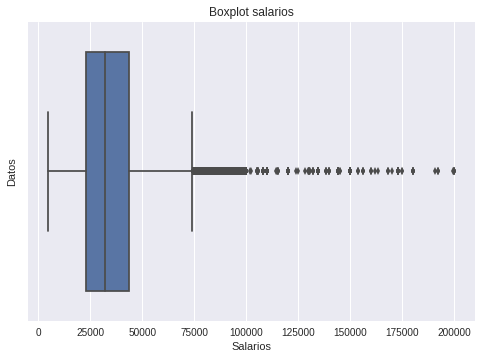

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(list(y_dataframe))
plt.title('Boxplot salarios')
plt.ylabel('Datos')
plt.xlabel('Salarios')
plt.show()

*Comentario: Se observa del grafico que la muestra esta sesgada hacia la izquierda concentrandose en el rango [20.000-40.000] quedando como outlayer los salarios mas elevados.*

Es por esto que se opta a normalizar los datos de salida del dataframe a continuación

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


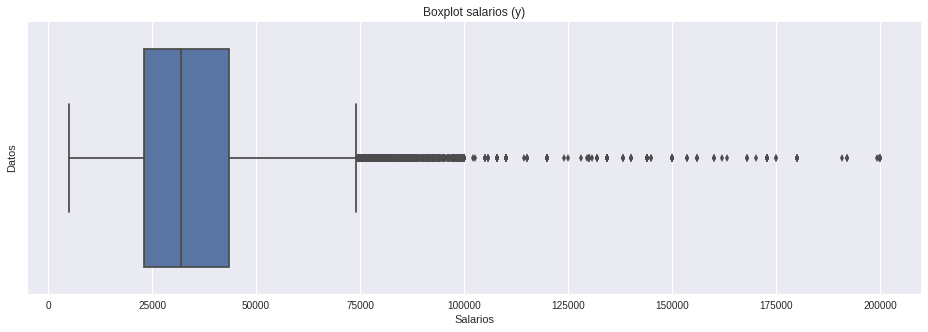

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


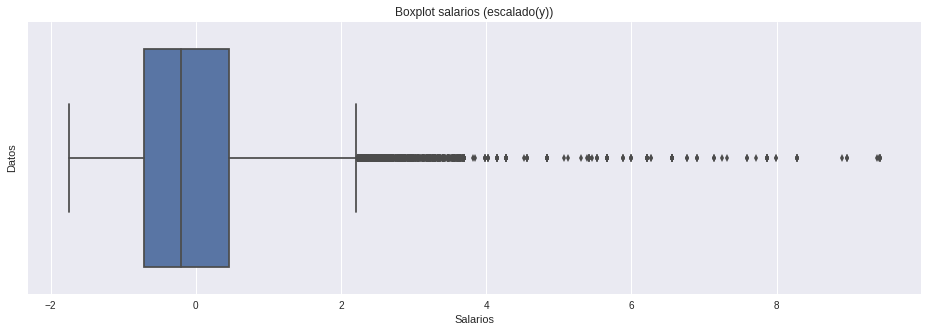

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


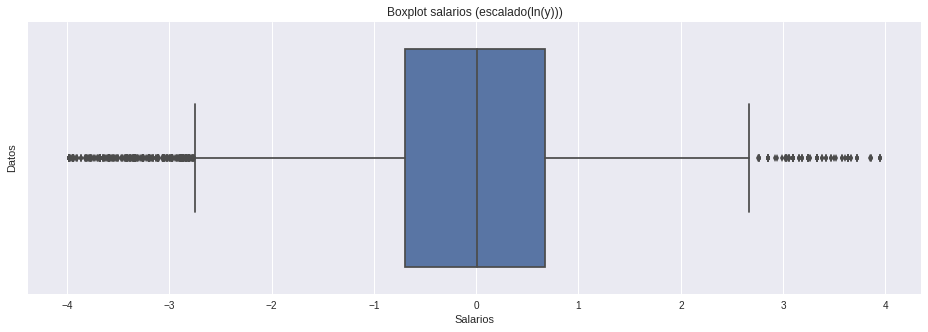

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

y_dataframe=df['SalaryNormalized']
sns.boxplot(list(y_dataframe))
plt.title('Boxplot salarios (y)')
plt.ylabel('Datos')
plt.xlabel('Salarios')
plt.show()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(y_dataframe.reshape(-1, 1))

sns.boxplot(list(df_scaled))
plt.title('Boxplot salarios (escalado(y))')
plt.ylabel('Datos')
plt.xlabel('Salarios')
plt.show()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(np.log(y_dataframe.reshape(-1, 1)))
y_dataframe=df_scaled

sns.boxplot(list(df_scaled))
plt.title('Boxplot salarios (escalado(ln(y)))')
plt.ylabel('Datos')
plt.xlabel('Salarios')
plt.show()

Posteriormente se pasa a crear los conjuntos de entrenamiento, validación y test

In [0]:
textoss=anuncios_pro["Anuncios"]
k=len(textoss)
x_train=textoss[0:int(k*0.70)] #70% training
x_val=textoss[int(k*0.70):int(k*0.85)] #15% validation
x_test=textoss[int(k*0.85):] #15% test

y_train=y_dataframe[0:int(k*0.70)] #70% training
y_val=y_dataframe[int(k*0.70):int(k*0.85)] #15% validation
y_test=y_dataframe[int(k*0.85):] #15% test

**Embeddings**

Se elabora el diccionario 'word_index' en el cual se gurdaran todas las distintas  palabras que aparecen en los anuncios del  'x_train' para la posterior construccion de la matrix  de embedding la cual se construira utilizando el archivo **Glove** el cual cuenta con las representaciones vectoriales (de dimensionalidad 100) ya entrenadas sobre una amplia base de datos. .

Text(0.5,1,'Distribucion de largo de textos')

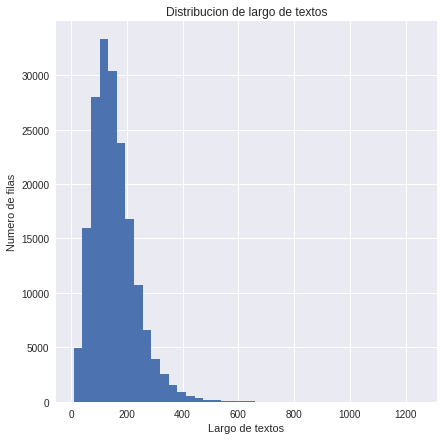

In [0]:
phrases_len = []
for row in textoss:
    phrases_len.append(len(row))

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(phrases_len, bins=40)
plt.xlabel("Largo de textos")
plt.ylabel("Numero de filas")
plt.title("Distribucion de largo de textos")

Se elabora el diccionario 'word_index' en el cual se gurdaran todas las distintas  palabras que aparecen en los anuncios del  'x_train' para la posterior construccion de la matrix  de embedding la cual se construira utilizando el archivo **Glove** el cual cuenta con las representaciones vectoriales (de dimensionalidad 100) ya entrenadas sobre una amplia base de datos. .

In [0]:
word_index=dict()
j=0
for frase in x_train:
    seq=frase
    for term in seq:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1

In [0]:
embeddings_index = {}
f = open(os.path.join('/content/gdrive/My Drive/ColabNoteb/glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Se encontraron 400000 terminos con sus vectores de embedding.


In [0]:
embedding_vector=100
embedding_matrix = np.zeros((len(word_index.keys()), embedding_vector))

In [0]:
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words sin match en Glove, serán vectores de ceros.
        embedding_matrix[i] = embedding_vector    

In [0]:
  embedding_matrix.shape

(112550, 100)

**Confección del Modelo:**

Se procede a realizar un muestreo sobre el diccionario para definir los vectores de entrada de entrenamiento, validación y test

In [0]:
from keras.preprocessing import sequence
x_new_train = [[word_index[word] for word in text] for text in x_train]
x_new_val = [[word_index[word] for word in text if word in word_index] for text in x_val]
x_new_test = [[word_index[word] for word in text if word in word_index] for text in x_test]

max_input_lenght = 225 #modificar este valor en base a su experimentación
Xtrain = sequence.pad_sequences(x_new_train,maxlen=max_input_lenght,padding='post',value=0)
Xval = sequence.pad_sequences(x_new_val,maxlen=max_input_lenght,padding='post',value=0)
Xtst = sequence.pad_sequences(x_new_test,maxlen=max_input_lenght,padding='post',value=0)

Se crean las primeras capas del modelo

In [ ]:
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D
embedding_vector=100
embedding_layer = Embedding(input_dim=len(word_index.keys()),output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)

Luego por medio de experimentación se logra dar con el mejor modelo posible, este se presenta a continuación

In [0]:
from keras.optimizers import SGD, Adam
cov1= Conv1D(128, 5, activation='relu',padding='same', W_regularizer=l2(0.001))(embedded_sequences)
dropp=Dropout(0.05)(cov1)
cov2= Conv1D(128, 5, activation='relu',padding='same', W_regularizer=l2(0.001))(dropp)
pool2 = MaxPooling1D(pool_size=3)(cov2)
dropx=Dropout(0.3)(pool2)
cov5= Conv1D(256, 8, activation='relu',padding='same', W_regularizer=l2(0.01))(dropx)
por=MaxPooling1D(pool_size=2)(cov5)
drop121=Dropout(0.05)(por)
cov6= Conv1D(256, 8, activation='relu',padding='same', W_regularizer=l2(0.01))(drop121)
pool3 = MaxPooling1D(pool_size=2)(cov6)
flat = Flatten()(pool3)
capa=Dense(2048,activation='relu')(flat)
drop=Dropout(0.3)(capa)
capa1=Dense(512,activation='relu')(drop)
drop3=Dropout(0.3)(capa1)
preds = Dense(1, activation='linear')(drop3)
model = Model(sequence_input, preds)
hist=History()
model.summary()
model.compile(loss='mse',optimizer='Adam')
model.fit(Xtrain, y_train, validation_data=(Xval, y_val),epochs=25, batch_size=352,callbacks=[hist])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(128, 5, activation="relu", padding="same", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(128, 5, activation="relu", padding="same", kernel_regularizer=<keras.reg...)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(256, 8, activation="relu", padding="same", kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(256, 8, activation="relu", padding="same", kernel_regularizer=<keras.reg...)`
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 225)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 225, 100)          11255000  
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 225, 128)          64128     
_________________________________________________________________
dropout_118 (Dropout)        (None, 225, 128)          0         
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 225, 128)          82048     
_________________________________________________________________
max_pooling1d_76 (MaxPooling (None, 75, 128)           0         
_________________________________________________________________
dropout_119 (Dropout)        (None, 75, 128)           0         
__________

Donde se ocupó un modelo de red profunda CxCxPxCxCxPxFxFxF, con el optimizador Adam, a continuación se grafica la evolución del error de entrenamiento y validación

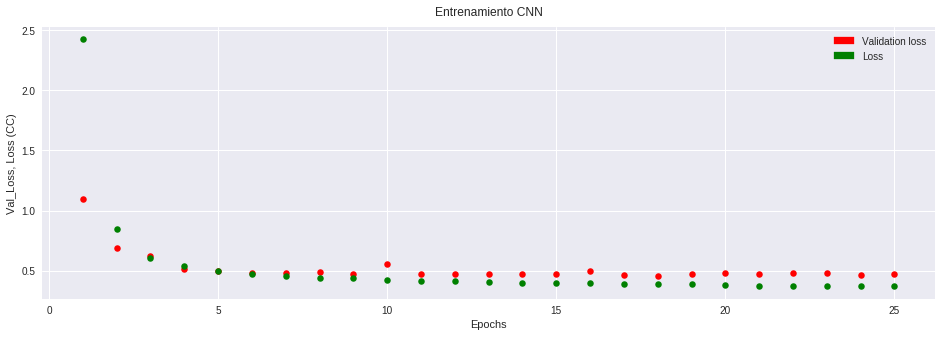

In [0]:
a=np.linspace(1,25,25)
plt.rcParams["figure.figsize"] = [16,5]
plt.title('Entrenamiento CNN',y=1.02)
plt.plot(a,hist.history['val_loss'],'r.',markersize=13)
red=mpatches.Patch(color='red', label='Validation loss')
plt.plot(a,hist.history['loss'],'g.', markersize=13)
green=mpatches.Patch(color='green', label='Loss')
plt.legend(handles=[red,green])
plt.xlabel('Epochs')
plt.ylabel('Val_Loss, Loss (CC)')
plt.show()

Finalmente se evalúa el conjunto de entrenamiento, validación y test por medio del mean absolute error, cabe resaltar que se debe desnormalizar tanto la salida de la red como la predicción de la red para obtener el error en la escala deseada

In [0]:
from sklearn.metrics import mean_absolute_error
print("MAE on train: ",mean_absolute_error(np.exp(scaler.inverse_transform(y_train)), np.exp(scaler.inverse_transform(model.predict(Xtrain)))))
print("MAE on validation: ",mean_absolute_error(np.exp(scaler.inverse_transform(y_val)),  np.exp(scaler.inverse_transform(model.predict(Xval)))))
print("MAE on test: ",mean_absolute_error(np.exp(scaler.inverse_transform(y_test)),  np.exp(scaler.inverse_transform(model.predict(Xtst)))))

MAE on train:  6049.663022567074
MAE on validation:  7992.564874865801
MAE on test:  7652.513982877578
